# The Timeseries Quantum Autoencoder (TS angle encoding)
*TS QAE in Qiskit with unary encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: August 2023 - January 2024<br>
Aims: The goal of this notebook is to build a Time Series Quantum Autoencoder, 
    a circuit which can compress a quantum state of a timeseries onto a smaller amount of qubits, 
    while retaining the information from the initial state.
Methods: A QAE model from Qiskit Tutorial 12 has been adopted for time series processing. 
- Time series data was converted to a series of sliding windows.
- Several approaches to TS data encoding were tested, i.e. unary, binary and anglular.
- Angle encoding was eventually used, with values centered around H state, in the range of [-pi/2..pi/2]
- The model featuring an input and encoder blocks only (followed by a swap test) was subsequently trained.
- A decoder was then added for testing, and the circuit initialised with an optimum set of parameters from training.
- Each test sample was then encoded into the full QAE circuit, which was executed using a state vector simulation.
- State vectors of input and output data was then visualised and compared. 

Sources: 
1. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. 2017. “Quantum Autoencoders for Efficient Compression of Quantum Data.” Quantum Science and Technology 2 (4): 045001.
2. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021
3. Qiskit Tutorial, https://qiskit.org/ecosystem/machine-learning/tutorials/12_quantum_autoencoder.html. *Based on [1].*
4. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
5. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.
6. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.

Notes:
- Refer to the end of the notebook for the log of changes
- Algorithm by Romera was followed
- Results of the enhanced algorithm by Bravo-Prieto could not be reproduced

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
!pip list | grep -E 'qiskit|torch'

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-experiments            0.5.4
qiskit-finance                0.4.0
qiskit-ibm-experiment         0.4.4
qiskit-ibm-provider           0.8.0
qiskit-ibm-runtime            0.18.0
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-terra                  0.45.2
torch                         2.0.1+cu118
torchaudio                    2.0.2+cu118
torchsummary                  1.5.1
torchvision                   0.15.2+cu118


In [3]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts/ts_denoise/qiskit_qae',
 '/home/jacob/miniconda3/envs/qiskit/lib/python39.zip',
 '/home/jacob/miniconda3/envs/qiskit/lib/python3.9',
 '/home/jacob/miniconda3/envs/qiskit/lib/python3.9/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit/lib/python3.9/site-packages',
 '.',
 '..']

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils.Target import *
from utils.Window import *
from utils.Callback import *

## Prepare windowed TS data
*Values need to be in [-1..+1] range*

### Prepare a time series

In [5]:
### Start random process
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 2022

### Data settings
samples = 10*20
train_pc = 0.7
samples_train = int(np.round(samples * train_pc, 0))
samples_valid = samples - samples_train
samples_hi_res = samples*2

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 9 # tested with: 6(-), 8(+), 10(?)
wind_padding = 0 # Not used
wind_step = 1
horizon = 1
scale = 1 # 2
pan = 0 # -1

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

### Define a target function params
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
eps = f.eps()
T = (ub - lb)

### Prepare all X and y data
X_all = np.linspace(lb, ub, num=samples_hi_res)
#y_all = f.fun(X_all)
# y_all = [round(x*scaler, 0) for x in f.fun(X_all)]
y_all = [(x*scale+pan) for x in f.fun(X_all)]
X_all = [x for x in range(len(X_all))]

### Split data into windows
# Create windowed time series, ignore X units
# However, as the task is not predictive, so the horizon is ignored

# The first set of windows  uses the orignal set of data
X_train_org, y_train_org, X_valid_org, y_valid_org = ts_wind_split(
    ts_wind_make(X_all, wind_size, wind_step), 
    ts_wind_make(y_all, wind_size, wind_step), 
    train_pc)

# The second set of windows uses consecitive value increments
y_deltas = []
prev = y_all[0]
for next in range(len(y_all)):
    y_deltas.append(y_all[next]-prev)
    prev = y_all[next]
    
X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = ts_wind_split(
    ts_wind_make(X_all, wind_size, wind_step), 
    ts_wind_make(y_deltas, wind_size, wind_step), 
    train_pc)

### Show TS parameters
print(f'Selected Data\n')
print(f'Function: {f.name}, Eps: {f.eps()}')
print(f'Samples: {samples}, Split: {train_pc}, Train Samples: {samples_train}, Valid Samples: {samples_valid}')
print(f'Window Size: {wind_size}, Step: {wind_step}, Horizon: {horizon}')
print(f'Range: {(round(lb, 3), round(ub, 3))}')
print(f'Training Range: {(round(lb_train, 3), round(ub_train, 3))}')
print(f'Validation Range: {(round(lb_valid, 3), round(ub_valid, 3))}')
print(f'T: {(round(ub-lb, 3))}')
print()
print(f'Training Windows: {X_train_ts.shape[0]}, Validation Windows: {X_valid_ts.shape[0]}')

Selected Data

Function: Target_2_sins, Eps: 0.1
Samples: 200, Split: 0.7, Train Samples: 140, Valid Samples: 60
Window Size: 9, Step: 1, Horizon: 1
Range: (-6.283, 6.283)
Training Range: (-6.283, 2.513)
Validation Range: (2.513, 6.283)
T: 12.566

Training Windows: 274, Validation Windows: 118


### Plot data

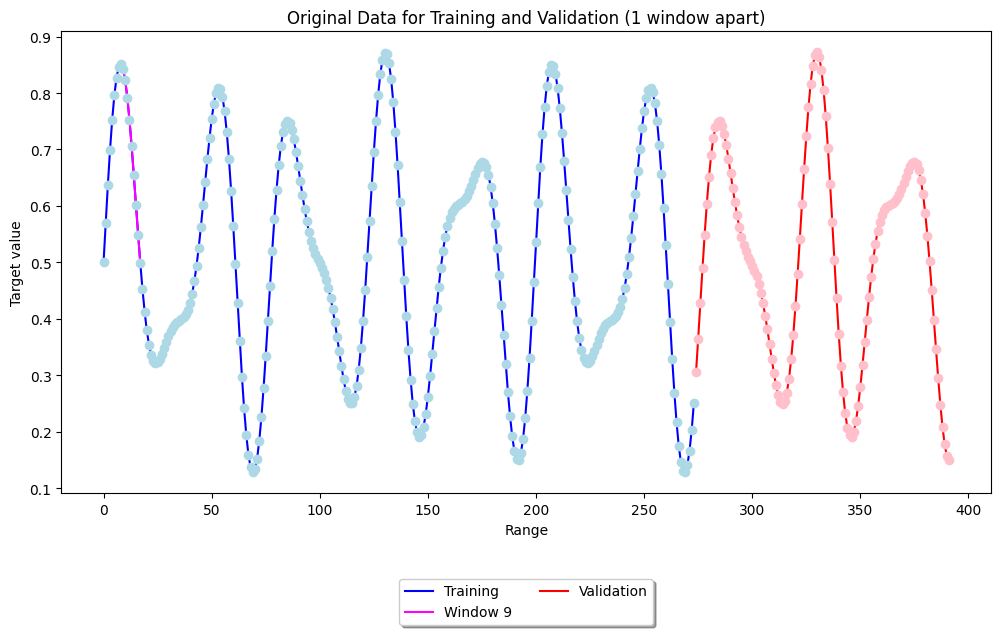


Sample Windows:

f([0,...,8]) ->
 [0.5, 0.57, 0.64, 0.7, 0.75, 0.8, 0.83, 0.85, 0.85]
f([1,...,9]) ->
 [0.57, 0.64, 0.7, 0.75, 0.8, 0.83, 0.85, 0.85, 0.84]
f([2,...,10]) ->
 [0.64, 0.7, 0.75, 0.8, 0.83, 0.85, 0.85, 0.84, 0.82]
f([3,...,11]) ->
 [0.7, 0.75, 0.8, 0.83, 0.85, 0.85, 0.84, 0.82, 0.79]
f([4,...,12]) ->
 [0.75, 0.8, 0.83, 0.85, 0.85, 0.84, 0.82, 0.79, 0.75]




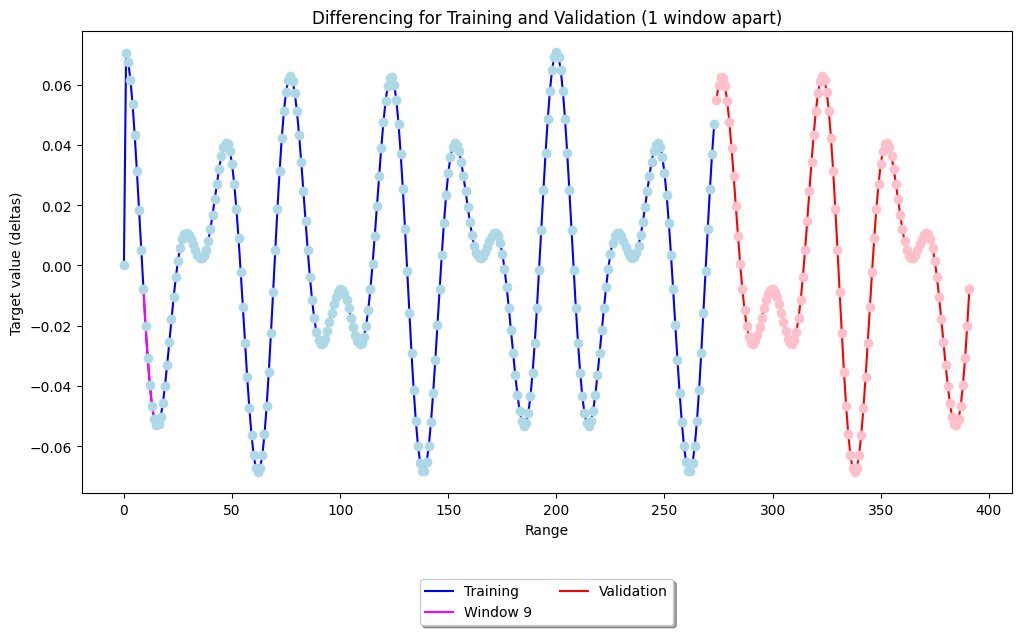


Sample Windows:

f([0,...,8]) ->
 [0.0, 0.07, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
f([1,...,9]) ->
 [0.07, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, -0.01]
f([2,...,10]) ->
 [0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, -0.01, -0.02]
f([3,...,11]) ->
 [0.06, 0.05, 0.04, 0.03, 0.02, 0.01, -0.01, -0.02, -0.03]
f([4,...,12]) ->
 [0.05, 0.04, 0.03, 0.02, 0.01, -0.01, -0.02, -0.03, -0.04]



In [6]:
# Window to highlight
sel_wind = 9

print()

# Plot the original time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Original Data for Training and Validation (1 window apart)")
plt.xlabel("Range")
plt.ylabel("Target value")
# plt.xlim(lb, ub)

# Plot target function
plt.plot([xt[0] for xt in X_train_org], [y[0] for y in y_train_org], color='blue', label='Training')
plt.plot(X_train_org[sel_wind], y_train_org[sel_wind], color='magenta', label='Window '+str(sel_wind))
plt.plot([xt[0] for xt in X_train_org], [y[0] for y in y_train_org], marker='o', color='lightblue', linestyle='None')
plt.plot([xv[0] for xv in X_valid_org], [y[0] for y in y_valid_org], color='red', label='Validation')
plt.plot([xv[0] for xv in X_valid_org], [y[0] for y in y_valid_org], marker='o', color='pink', linestyle='None')
# plt.plot(X_all, y_all, marker='o', color='lightblue', linestyle='None')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

print(f'\nSample Windows:\n')
for i in range(5):
    print(f'f([{round(X_train_org[i][0], 2)},...,{round(X_train_org[i][-1], 2)}]) ->\n {[round(v, 2) for v in y_train_org[i]]}')
print()
print()

# Plot deltas in the time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Differencing for Training and Validation (1 window apart)")
plt.xlabel("Range")
plt.ylabel("Target value (deltas)")
# plt.xlim(lb, ub)

# Plot target function
plt.plot([xt[0] for xt in X_train_ts], [y[0] for y in y_train_ts], color='blue', label='Training')
plt.plot(X_train_ts[sel_wind], y_train_ts[sel_wind], color='magenta', label='Window '+str(sel_wind))
plt.plot([xt[0] for xt in X_train_ts], [y[0] for y in y_train_ts], marker='o', color='lightblue', linestyle='None')
plt.plot([xv[0] for xv in X_valid_ts], [y[0] for y in y_valid_ts], color='red', label='Validation')
plt.plot([xv[0] for xv in X_valid_ts], [y[0] for y in y_valid_ts], marker='o', color='pink', linestyle='None')
# plt.plot(X_all, y_all, marker='o', color='lightblue', linestyle='None')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

print(f'\nSample Windows:\n')
for i in range(5):
    print(f'f([{round(X_train_ts[i][0], 2)},...,{round(X_train_ts[i][-1], 2)}]) ->\n {[round(v, 2) for v in y_train_ts[i]]}')
print()

### Utilities

In [7]:
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_state_city, plot_state_paulivec
from qiskit import Aer

In [8]:
# Converts measurements amplitudes a and b in a|0>+b|1> into bloch vector
def convert_amps_to_xyz(a, b):
    x = 2*np.real(a*np.conjugate(b))
    y = 2*np.imag(b*np.conjugate(a))
    z = a*np.conjugate(a)-b*np.conjugate(b)
    return [x, y, z] 

### Angle encoding
Deltas between consecutive time series values have been angle encoded. In the context of a quibit representation (see the Figure), the encoding assumes zero to be encoded as H state, negative values to be rotations up, while positive values as rotations down. This encoding allows cumulative sequence calculations and easy value decoding upong the qubit measurements. Should there be huge voilatility in data, additional scaling has been added to shrink the region of valid angular qubit positions. 

<div>
    <!--img src="attachment:qae_fig2_wide.png" width="1000"-->
    <img src="../images/seq-value-encoding.png" width="300">
</div>

**Figure: Sequence value coding as qubit angular rotations**

In [9]:
### Angle encoding of a TS value relative to the previous value
#   val: value in [-1..+1] range to be encoded
#   optional scaler=np.pi/2: Number scaler 
#   optional err_range=0/0.05: allows range scaling to cater for accumulating errors
#   returns: Encoding of the next value relative to the previous value
def ts_relang_encode_val(val, scaler=np.pi/2, err_range=0):
    return val * scaler * (1 - 2 * err_range)

### Decoding
def ts_relang_decode_val(val, scaler=np.pi/2, err_range=0):
    return val / (scaler * (1 - 2 * err_range))

### Normalises the value to 1 (not required with angle encoding)
def ts_relang_norm_val(next_code):
    norm_code = next_code
    return norm_code

### Print encoding and decoding for testing
def print_ts_relang_encode_val(n):
    val = round(ts_relang_encode_val(n), 3)
    if val == 0:
        print(f'{(n)} -> {val} (π*{0.0})')
    else:
        print(f'{(n)} -> {val} (π/{round(np.pi / val, 3)})')
    
def print_ts_relang_decode_val(n):
    if n == 0:
        print(f'{round(n, 3)} (π*{0.0}) -> {ts_relang_decode_val(n)}')
    else:
        print(f'{round(n, 3)} (π/{round(np.pi / n, 3)}) -> {round(ts_relang_decode_val(n), 3)}')

def print_ts_relang_norm_val(p):
    print(f'{round(p, 3)} -> {round(ts_relang_norm_val(p), 3)}')

### Test
# print('Encoding:')
# print_ts_relang_encode_val(0)
# print_ts_relang_encode_val(0.5)
# print_ts_relang_encode_val(0.7)
# print_ts_relang_encode_val(0.25)
# print_ts_relang_encode_val(1.2) # Out of [0..pi] range
# print_ts_relang_encode_val(-0.7) # Out of [0..pi] range

# print('\nDecoding:')
# print_ts_relang_decode_val(np.pi)
# print_ts_relang_decode_val(0*np.pi)
# print_ts_relang_decode_val(np.pi/4)
# print_ts_relang_decode_val(-np.pi/2)
# print_ts_relang_decode_val(np.pi/8)
# print_ts_relang_decode_val(-0.9*np.pi) # Out of [0..pi] range

# print('\nNormalise Encoding:')
# print_ts_relang_norm_val(1.5*np.pi)
# print_ts_relang_norm_val(-0.5*np.pi)

In [10]:
### Encoding the entire data set
def ts_relang_encode(wind_set, scaler=np.pi):
    encoded_set = []
    for wind_idx in range(wind_set.shape[0]):
        wind = wind_set[wind_idx]
        encoded_wind = []
        for val_idx in range(wind.shape[0]):
            val = wind[val_idx]
            encoded_val = ts_relang_encode_val(val, scaler)
            encoded_wind.append(encoded_val)
        encoded_set.append(encoded_wind)
    org_wind_start = np.array([w[0] for w in wind_set])
    return np.array(encoded_set), org_wind_start

### Encoding the entire data set
def ts_relang_decode(org_wind_start, encoded_wind_set, scaler=np.pi):
    decoded_set = []
    for wind_idx in range(encoded_wind_set.shape[0]):
        wind = encoded_wind_set[wind_idx]
        decoded_wind = []
        for val_idx in range(wind.shape[0]):
            encoded_val = wind[val_idx]
            decoded_val = ts_relang_decode_val(encoded_val, scaler)
            decoded_wind.append(decoded_val)
            prev = decoded_val
        decoded_set.append(decoded_wind)
    return np.array(decoded_set)

### In agle encoding, encoded data is already normalised
def ts_relang_norm(encoded_wind_set):
    return np.array(encoded_wind_set)

### Preparing data for training and testing

In [11]:
y_train_enc, org_train_start = ts_relang_encode(y_train_ts)
y_valid_enc, org_valid_start = ts_relang_encode(y_valid_ts)

### Testing validation windows

# y_train_dec = ts_relang_decode(org_train_start, ts_relang_norm(y_train_enc))
# print('\nTraining windows before encoding:\n', y_train_ts[5:8])
# print('\nTraining windows after encoding:\n', y_train_enc[5:8])
# print('\nTraining windows org start:\n', org_train_start[5:8])
# print('\nTraining windows after decoding:\n', y_train_dec[5:8])

# y_valid_dec = ts_relang_decode(org_valid_start, y_valid_enc)
# print('\nValidation windows before encoding:\n', y_valid_ts[0:8])
# print('\nValidation windows after encoding:\n', y_valid_enc[0:8])
# print('\nValidation windows org start:\n', org_valid_start[0:8])
# print('\nValidation windows after decoding:\n', y_valid_dec[0:8])

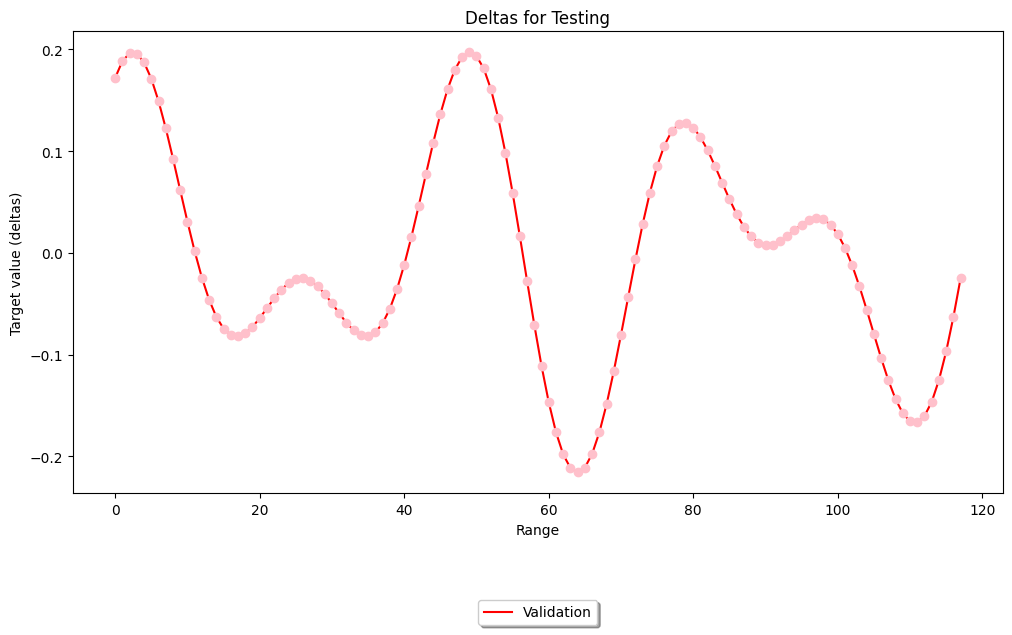

In [12]:
# Plot deltas in the time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Deltas for Testing")
plt.xlabel("Range")
plt.ylabel("Target value (deltas)")

sel_range=range(len(y_valid_enc))
#sel_range=range(70, 100, 1)
#sel_range=range(10, 40, 1)

plt.plot(list(sel_range), [y[0] for y in y_valid_enc[sel_range]], color='red', label='Validation')
plt.plot(list(sel_range), [y[0] for y in y_valid_enc[sel_range]], marker='o', color='pink', linestyle='None')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

## Building and training a Quantum Autoencoder

In [13]:
### Libraries used in QAE development

import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, NELDER_MEAD
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit import Parameter

In [37]:
### Constants used in setting QAE parameters

reps=4
ent='sca' # linear, reverse_linear, full, circular, sca
num_trash = 3
num_latent = wind_size-num_trash

algorithm_globals.random_seed = 42

print(f'Ansatz: reps={reps}, '+
      f'ent={ent}, '+
      f'num_trash={num_trash}, '+
      f'num_latent={num_latent}, '+
      f'training qubits={num_latent + 2 * num_trash + 1}, '+
      f'testing qubits={num_trash+num_latent}')

Ansatz: reps=4, ent=sca, num_trash=3, num_latent=6, training qubits=13, testing qubits=9


### Sequence encoder
The sequence is encoded as a series of angle rotations

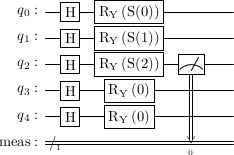


Input parameters for the sequence:  [Parameter(S(0)), Parameter(S(1)), Parameter(S(2))]


In [38]:
### Creates a circuit encoding a sequence 
#   - Adds H gates to position each qubit at a "zero" position
#   - Each sequence value y-rotates the qubit state either up (negative) or down (positive)
#   - Use only as many input values as the number of qubits, if not enough provided zero rotations are added
#
#   qubits_no: Number of qubits
#   input_no: Number of values in a sequence
#   optional classreg=False: Flag indicating if a classical register is to be added
#   optional meas_q=None: Indicates the qubit to be measured, active only when classreg=True
#   returns: Circuit encoding a sequence
def sequence_encoder(qubit_no, input_no=None, classreg=False, meas_q=None):

    if input_no == None: 
        input_no = qubit_no
    used_sgates = 0
    label = 'S'

    qr = QuantumRegister(qubit_no, 'q')
    cr = ClassicalRegister(1, 'meas')
    if classreg:
        seq = QuantumCircuit(qr, cr, name='sequence')
    else:
        seq = QuantumCircuit(qr, name='sequence')

    # Data-encoding circuit block, packs different input vars
    for q in range(qubit_no):
        seq.h(q)
        if q > input_no:
            seq.ry(0, q)
        else:
            param_x = Parameter(label+'('+str(used_sgates)+')') if used_sgates < input_no else 0
            seq.ry(param_x, q)
        used_sgates += 1

    if classreg and meas_q != None:
        seq.measure(meas_q, 0)

    return seq, seq.parameters[:]

### Test a sample sequence encoder
test_seq, inp_params = sequence_encoder(5, 3, classreg=True, meas_q=2)
print('\n')
display(test_seq.draw(output='latex', style="iqp", fold=False, scale=0.7))
print('\nInput parameters for the sequence: ', inp_params)

**Figure: Example of encoding for a sample sequence window**

### Creation of an ansatz

The selectede ansatz is the Qiskit RealAmplitude ansatz (2-local circuit) - the prepared quantum states will only have real amplitudes, and does not rely on full connectivity between qubits. 

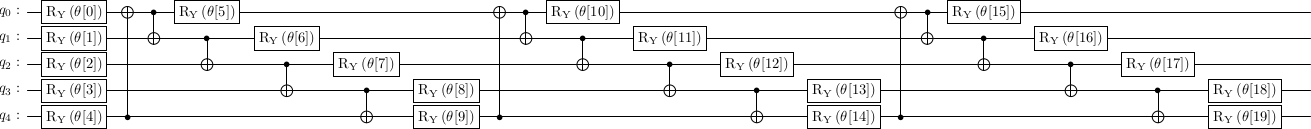


Number of ansatz parameters: 20



In [39]:
### Creates an ansatz to be used for QAE Encoder/Decoder
#   num_latent: size of the latent area
#   num_trash: size of the trash area
#   reps: number of repeating layers
#   ent: type of entanglement layer 

# Standard ansatz based Ry and Cx
def ansatz_ra(num_latent, num_trash, reps=3, ent='circular'):
    anz = RealAmplitudes(num_latent+num_trash, reps=reps, entanglement=ent)
    return anz

# Selected ansatz
def ansatz(num_latent, num_trash, reps=3, ent='circular'):
    return ansatz_ra(num_latent, num_trash, reps=reps, ent=ent)

### Test the selected ansatz
test_ansatz = ansatz(3, 2, reps=3, ent='circular') # linear, reverse_linear, full, circular, sca
print('\n')
display(test_ansatz.decompose().draw("latex", style="iqp", scale=0.7, fold=False))
print(f'\nNumber of ansatz parameters: {len(test_ansatz.parameters)}\n')

**Figure: Sample QAE ansatz**

### Training Circuit - Sequence + Encoder + Swap Test


Example autoencoder circuit:



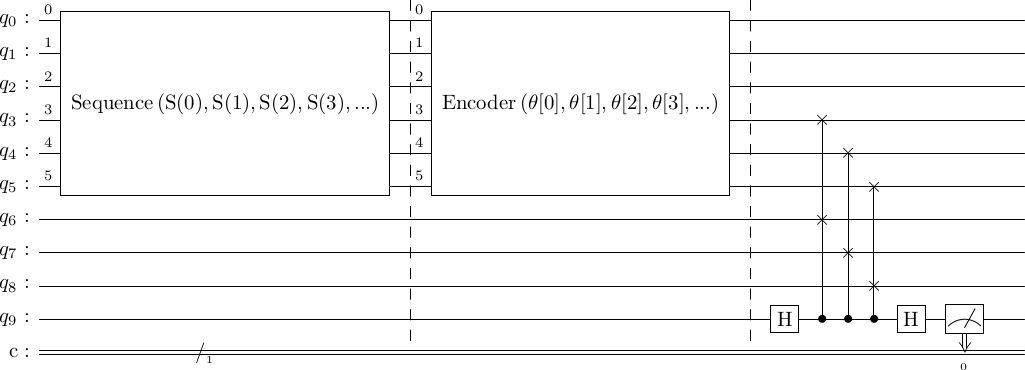


Number of trash qubits k=3
Number of latent qubits n=6



In [40]:
### Building partial QAE for its training

def auto_encoder_circuit(num_latent, num_trash, reps=4, ent='circular'):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    fm_qc, _ = sequence_encoder(num_latent + num_trash)
    fm_qc.name = 'Sequence'
    anz_qc = ansatz(num_latent, num_trash, reps=reps, ent=ent).decompose()
    anz_qc.name = 'Encoder'
    
    circuit = QuantumCircuit(qr, cr)
    circuit.append(fm_qc, qargs=range(num_latent+num_trash))
    circuit.barrier()
    circuit.append(anz_qc, qargs=range(num_latent + num_trash))
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)    
    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit, fm_qc, anz_qc

### Test a training circuit
sample_ae, _, _ = auto_encoder_circuit(3, 3, reps=2, ent='full')
print('\nExample autoencoder circuit:\n')
display(sample_ae.draw("latex", style="iqp", scale=1))
print(f'\nNumber of trash qubits k={num_trash}')
print(f'Number of latent qubits n={num_latent}\n')

**Figure: QAE structure for its training (using Encoder and a Swap Test)**<br/>
Again, we can see the swap test being performed on the selected qubits to determine the value of our cost function.

### Testing Circuit - The entire QAE

The full Autoencoder consists of both the Encoder and Decoder, which is simply an inverted Encoder. 
Both the Encoder and Decoder can be initialised using the same parameters obtained from the Encoder (plus swap test) training.
By applying the full QAE circuit to a test dataset, we can then determine the model accuracy.

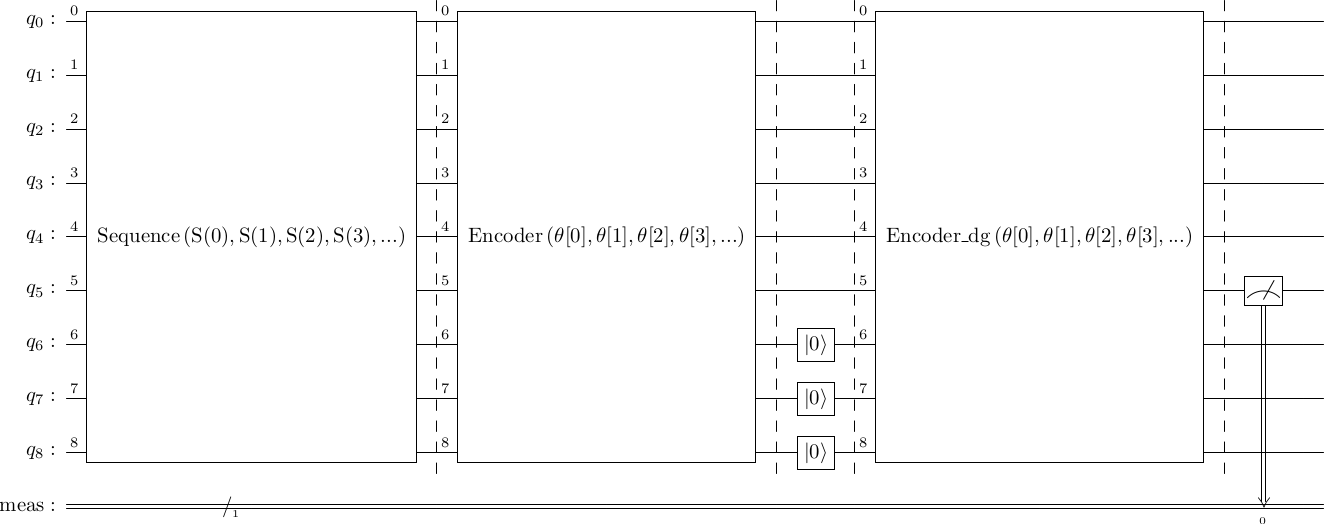


#QAE Input Parameters: 9 (274, 9)
#Encoder/Decoder Weights: 45
#QAE Total Weights: 54



In [41]:
### Full QAE for testing the previously trained model

def qae(lat_no, trash_no, reps=3, ent='sca', classreg=False, meas_q=None):

    # Prepare a circuit
    qr = QuantumRegister(lat_no + trash_no, 'q')
    cr = ClassicalRegister(1, 'meas')
    # qae_qc = QuantumCircuit(lat_no + trash_no, 1)
    if classreg:
        qae_qc = QuantumCircuit(qr, cr, name='qae')
    else:
        qae_qc = QuantumCircuit(qr, name='qae')

    # Create all QAE components
    fm_qc, _ = sequence_encoder(lat_no + trash_no)
    fm_qc.name = 'Sequence'
    ansatz_qc = ansatz(lat_no, trash_no, reps=reps, ent=ent)
    ansatz_qc.name = 'Encoder'

    # Create a circuit
    qae_qc.append(fm_qc, qargs=range(lat_no + trash_no))
    qae_qc.barrier()
    qae_qc.append(ansatz_qc, qargs=range(lat_no + trash_no))
    qae_qc.barrier()
    
    for i in range(num_trash):
        qae_qc.reset(lat_no + i)
    
    qae_qc.barrier()
    ansatz_inv_qc = ansatz_qc.inverse()
    qae_qc.append(ansatz_inv_qc, qargs=range(lat_no + trash_no))

    # Add optional measurement
    if classreg and meas_q != None:
        qae_qc.barrier()
        qae_qc.measure(meas_q, 0)

    return qae_qc, fm_qc, ansatz_qc

test_qae_qc, fm_qc, an_qc = qae(num_latent, num_trash, reps=reps, ent=ent, classreg=True, meas_q=5)

### Show a sample test circuit - the sequence feature map and the ansatz will beused further
print('\n')
display(test_qae_qc.draw("latex", style="iqp", scale=1))
print('\n#QAE Input Parameters:', len(fm_qc.parameters), y_train_enc.shape)
print('#Encoder/Decoder Weights:', len(an_qc.parameters))
print('#QAE Total Weights:', len(test_qae_qc.parameters))
print()

**Figure: Full QAE capable of mapping input sequence to its output (after Encoder training)**

## Model training

**Sampler** needs to be imported from *qiskit_aer.primitives*.
Unfortunately, *qiskit-aer-gpu 0.12.2* has a bug, which has been fixed 
in the next version *qiskit-aer-gpu 0.13.0*, see notes in the version table.

### Computational device for the simulator

In [42]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

('CPU', 'GPU')

In [43]:
# Force the CPU due to error on Jacob's machine, delete if needed
devices = ('CPU')
devices

'CPU'

### Sampler options

In [44]:
### Create a sampler suitable for the device
#   GPU methods: statevector, tensor_network, density_matrix, unitary

from qiskit.primitives import Sampler # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Sampler as AerSampler # For device="GPU" option

seed = 2023

# Use GPU when present, otherwise CPU
if 'GPU' in devices:
    device = 'GPU'
    sampler = AerSampler(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': 1000},
        transpile_options={"seed_transpiler": seed},
    )
else:
    device = 'CPU'
    sampler = Sampler()
    sampler.set_options(method='statevector')
    sampler.set_options(device=device)
    sampler.set_options(seed=seed)
    sampler.options

print(f'Selected device: {device}')

Selected device: CPU


### Cost function
We build our cost function, based on the swap test between the reference and trash space for the digit dataset. To do this, we again use Qiskit's CircuitQNN network and use the same interpret function as we are measuring the probability of getting the final qubit in the $|1\rangle$ state.

In [45]:
def cost_func_tswind(params_values):
    probabilities = qnn.forward(y_train_enc, params_values)
    cost = np.sum(probabilities[:, 1]) / y_train_enc.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Cost function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Cost function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

### Setting the initial point
Since model training may take a long time we have already pre-trained the model for some iterations and saved the pre-trained weights. We'll continue training from that point by setting `initial_point` to a vector of pre-trained weights.

In [46]:
saved_starting_point = False
init_file_name = f'qae_angle_{ent}_reps{reps}_p{len(an_qc.parameters)}_init.json'

if saved_starting_point:
    ### Using previously saved init point
    print(f'Using previously saved init parameters from file "{init_file_name}"')
    epochs = 200 
    with open(init_file_name, 'r') as f:
        initial_point = json.load(f)
else:
    ### Using a random init point
    print(f'Random init parameters to be saved to file "{init_file_name}"')
    epochs = 500 
    initial_point = algorithm_globals.random.random(an_qc.num_parameters)

Random init parameters to be saved to file "qae_angle_sca_reps4_p45_init.json"


By minimizing this cost function, we can thus determine the required parameters to compress our noisy images. Let's see if we can encode our images! 

### QAE training

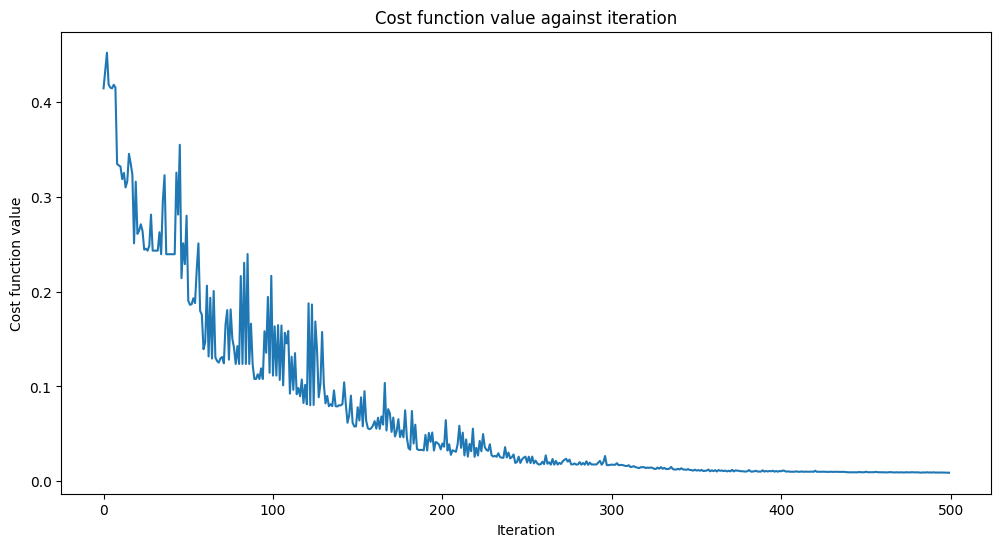

CPU Fit (274 samples, 9 qubits, 45 params, 500 epochs): 0.00907 min cost, 3603.48 sec


In [47]:
training_required = True

def identity_interpret(x):
    return x

first_only = lambda x: x % 2

if training_required:
    
    print('Training initiated, optmum parameters will be calculated')
    
    train_ae_qc, _, _ = auto_encoder_circuit(num_latent, num_trash, reps=reps, ent=ent)

    qnn = SamplerQNN(
        circuit=train_ae_qc,
        input_params=fm_qc.parameters,
        weight_params=an_qc.parameters,
        interpret=identity_interpret,
        output_shape=2,
        sampler=sampler
    )
    
    opt = COBYLA(maxiter=epochs)
    
    objective_func_vals = []
    # make the plot nicer
    plt.rcParams["figure.figsize"] = (12, 6)
    
    start = time.time()
    opt_result = opt.minimize(fun=cost_func_tswind, x0=initial_point)
    optimum_parameters = opt_result.x
    minimum_cost = opt_result.fun
    elapsed = time.time() - start

    # Print run statistics
    print(f'{device} Fit ('+
          f'{y_train_enc.shape[0]} samples, '+
          f'{y_train_enc.shape[1]} qubits, '+
          f'{len(an_qc.parameters)} params, '+
          f'{epochs} epochs): '+
          f'{round(minimum_cost, 5)} min cost, '+
          f'{elapsed:0.2f} sec')

elif saved_starting_point:
    optimum_parameters = initial_point
    print('Training skipped, previously saved optimum parameters will be used here')
else:
    optimum_parameters = initial_point
    print('Training skipped, optmum parameters were generated randomly')    

In [48]:
to_be_saved_starting_point = False

if to_be_saved_starting_point:
    ## Saving the initialisation point
    with open(init_file_name, 'w') as f:
        json.dump(opt_result.x.tolist(), f)
    print(f'Saved optimum parameters as the future starting point, in: {init_file_name}')
else:
    print(f'Parameters not saved') 

Parameters not saved


## Model testing
Note that all components of a test circuit will be built in the testing process

In [49]:
### Select a backend

backend = Aer.get_backend('aer_simulator_statevector')
# backend = Aer.get_backend('aer_simulator')

### Measuring the state of a single qubit in a circuit (in terms of its y angle)

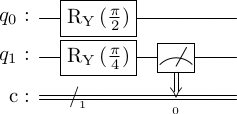

-0.25

In [50]:
### Runs a circuit with a single qubit measured and returns its angular position
#   Recall the figure explaining encoding

def single_qubit_angle_meas(qc, backend, shots=10000):
    job = backend.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    counts0 = counts['0'] if '0' in counts.keys() else 0
    counts1 = counts['1'] if '1' in counts.keys() else 0
    p0 = counts0/(counts0+counts1)
    p1 = counts1/(counts0+counts1)
    amp0 = np.sqrt(p0)
    amp1 = np.sqrt(p1)

    meas_angle = 2*np.arccos(amp0)-np.pi/2
    return meas_angle

# Test
qc = QuantumCircuit(2, 1)
qc.ry(np.pi/2, 0)
qc.ry(np.pi/4, 1)
qc.measure(1, 0)
print()
display(qc.draw("latex", style="iqp", scale=1))
angle = single_qubit_angle_meas(qc, backend)
round(angle / np.pi, 2)

### Running and analysing tests for the selected TS windows

In [55]:
### Select a collection of windows to test

sel_wind_set = list(range(30))
# sel_wind_set = [1, 2, 3, 4, 5, 10, 20, 21, 22, 23, 30]
# sel_wind_set = [1, 2, 5]
# sel_wind_set = [35, 37, 50]
in_org_set = {}
in_meas_set = {}
out_reconstr_set = {}

print(f'Selected {len(sel_wind_set)} windows to process')

Selected 30 windows to process


In [56]:
### Calculate measured input data (for comparison) and reconstructed input data

print(f'Processed window: ', end=' ')
for wind_idx in range(len(sel_wind_set)):

    sel_wind = sel_wind_set[wind_idx]
    wind_valid_params = y_valid_enc
    wind = wind_valid_params[sel_wind]

    ### Find the QAE input window state vector representation (as measured)
    org_meas = []
    for meas_q in range(len(wind)):
        org_qc, _ = sequence_encoder(num_latent + num_trash, wind_size, classreg=True, meas_q=meas_q)
        org_qc = org_qc.assign_parameters(wind)
        meas_angle = single_qubit_angle_meas(org_qc, backend, shots=10000)
        org_meas.append(meas_angle)

    ### Find the QAE resulting window state vector representation
    out_meas = []
    for meas_q in range(len(wind)):
        param_values = np.concatenate((wind, optimum_parameters))

        out_qc, _, _ = qae(num_latent, num_trash, reps=reps, ent=ent, classreg=True, meas_q=meas_q)     
        out_qc = out_qc.assign_parameters(param_values)
        out_qc = out_qc.decompose().decompose()
        meas_angle = single_qubit_angle_meas(out_qc, backend, shots=10000)
        out_meas.append(meas_angle)

    ### Add window results
    in_org_set[sel_wind] = list(wind)
    in_meas_set[sel_wind] = org_meas
    out_reconstr_set[sel_wind] = out_meas    

    print(f'{sel_wind}', end=' ')

print('End\n')

Processed window:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 End



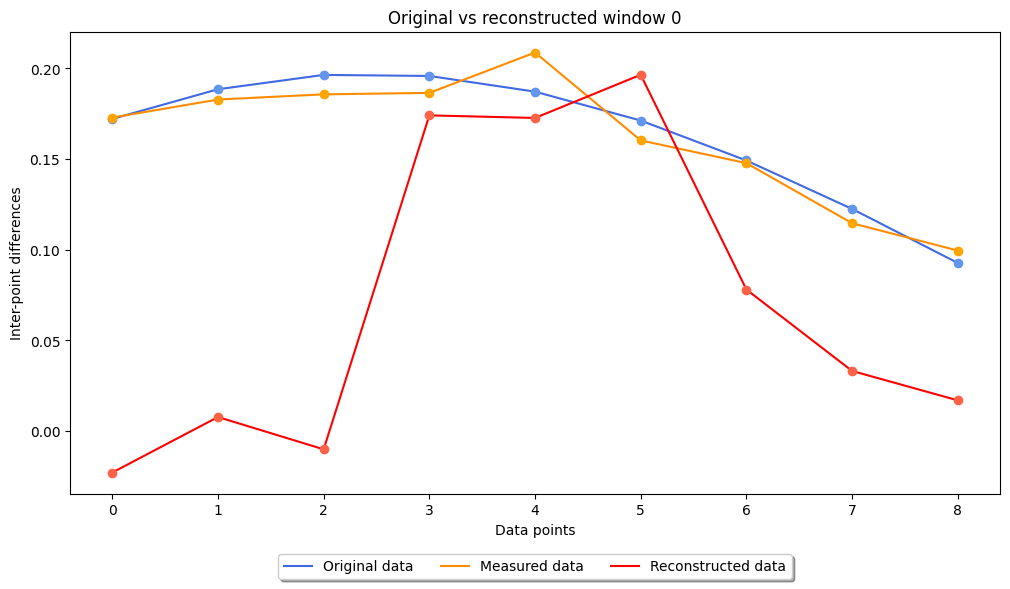

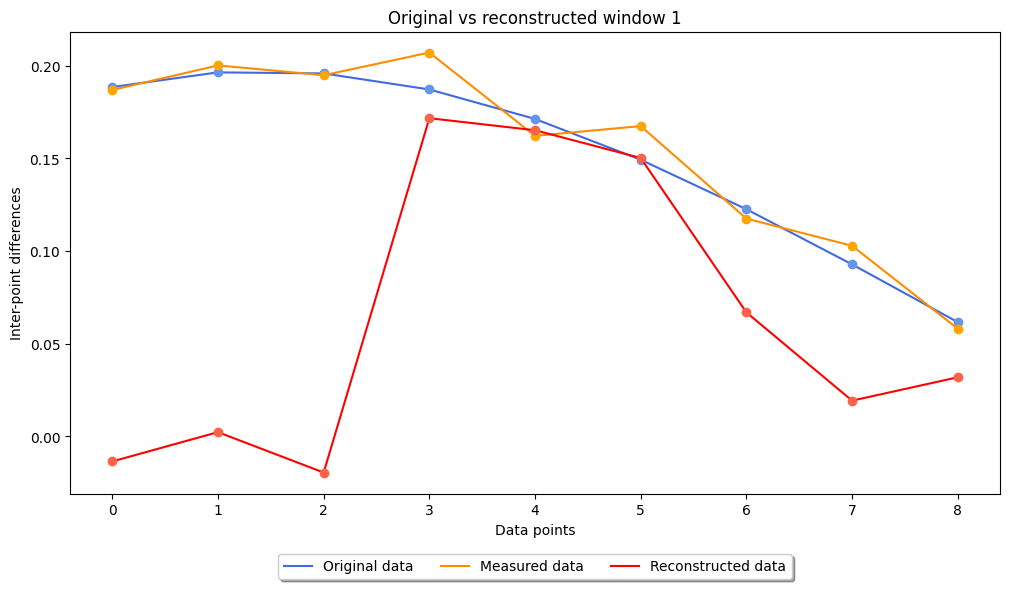

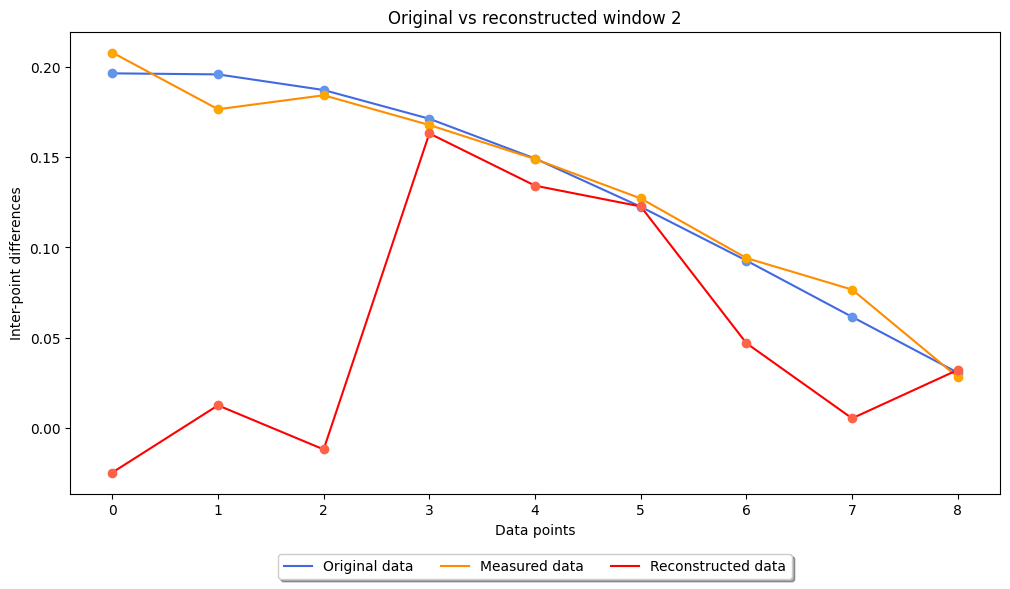

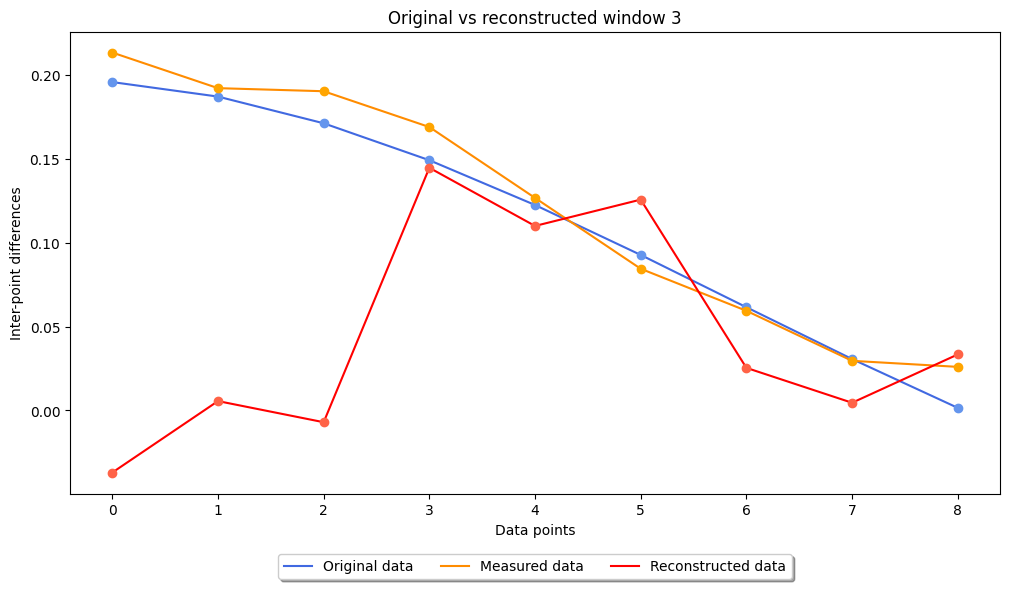

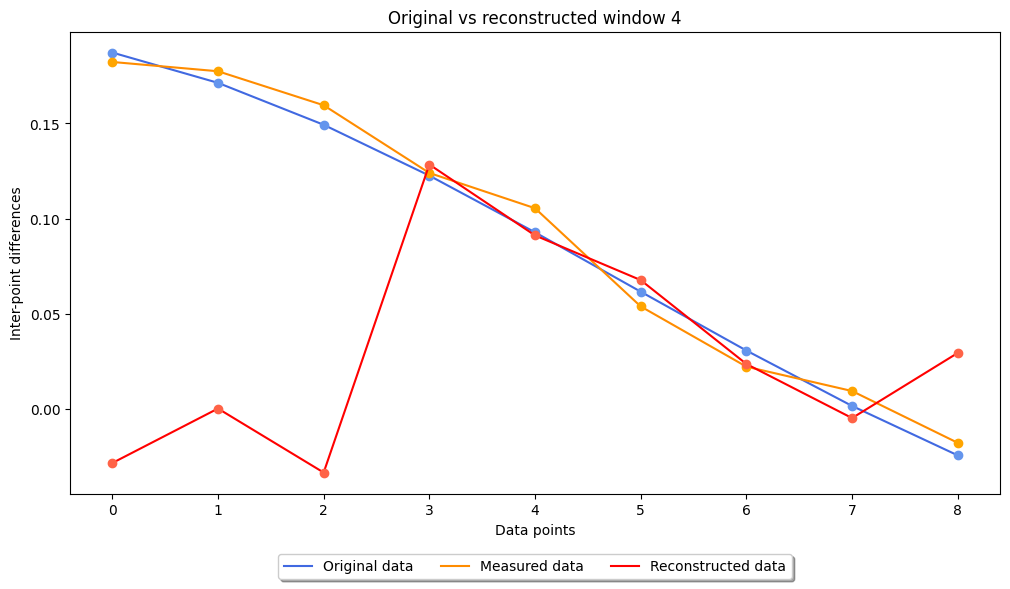

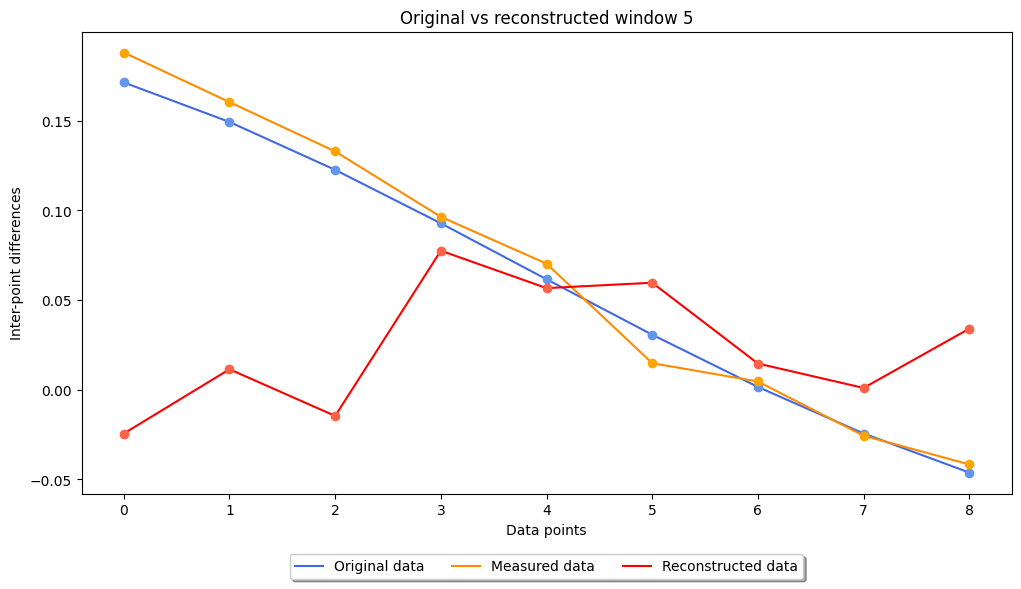

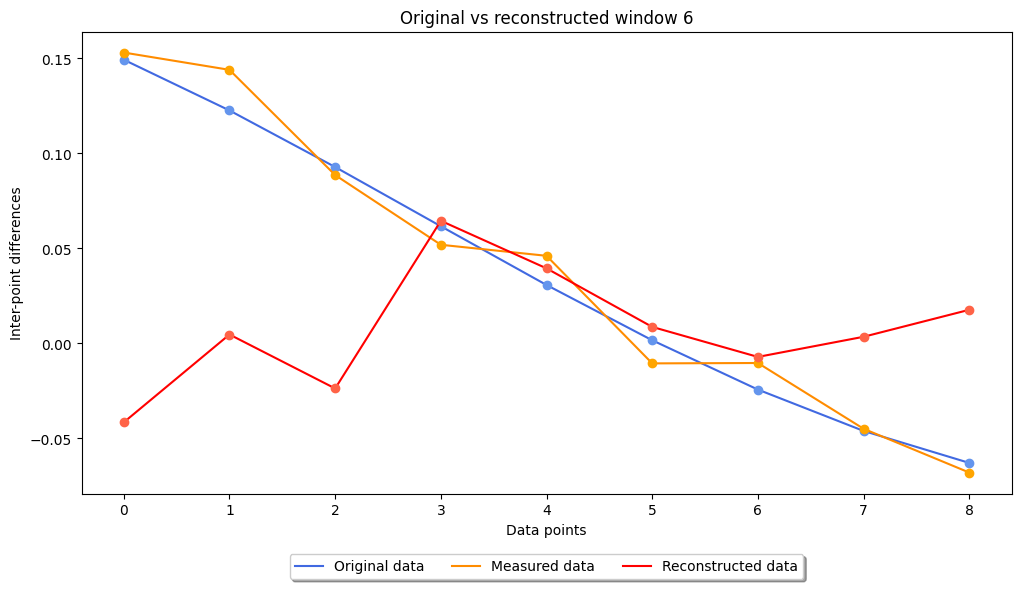

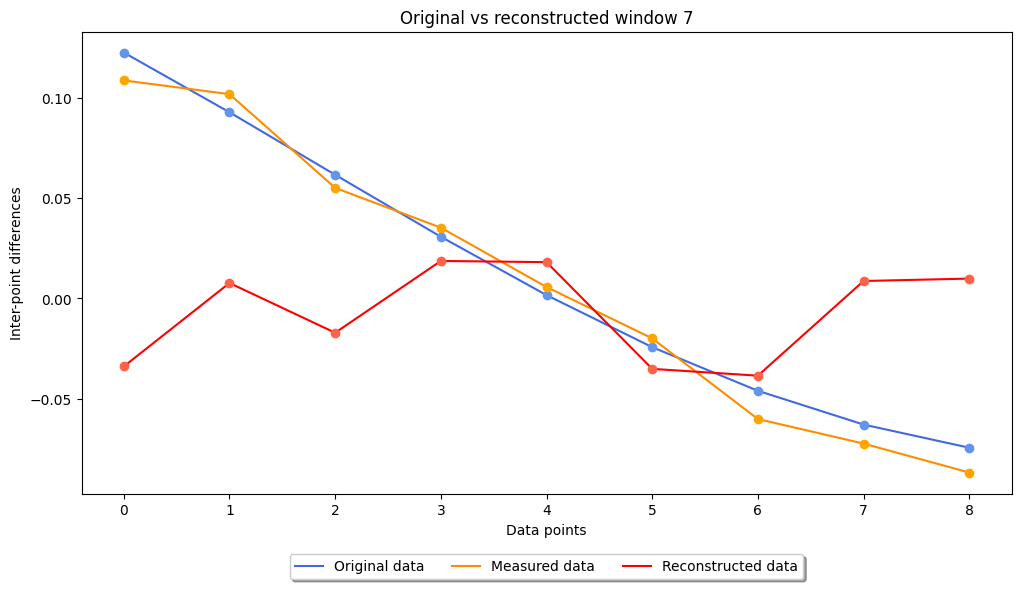

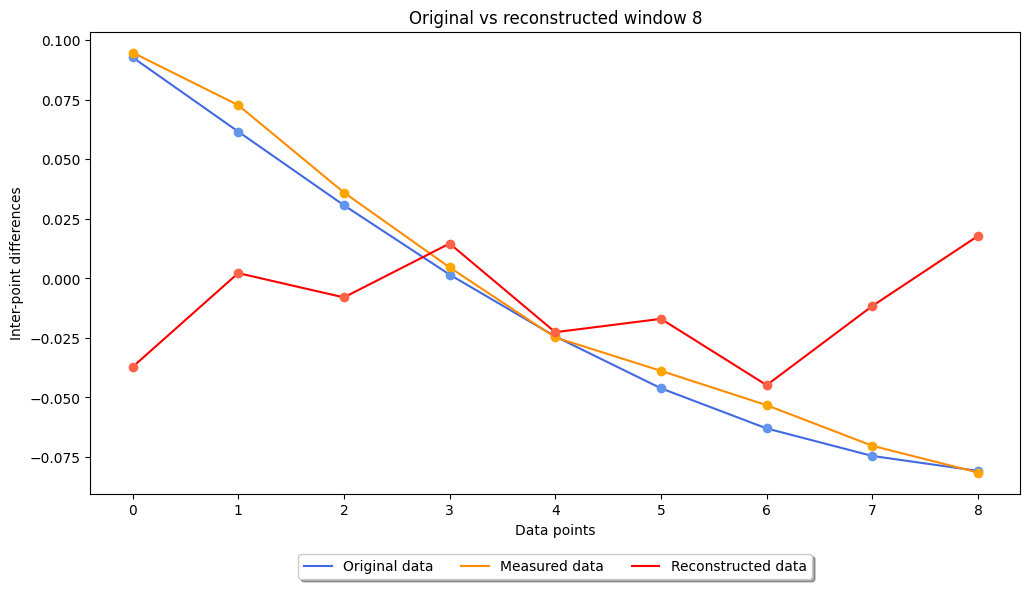

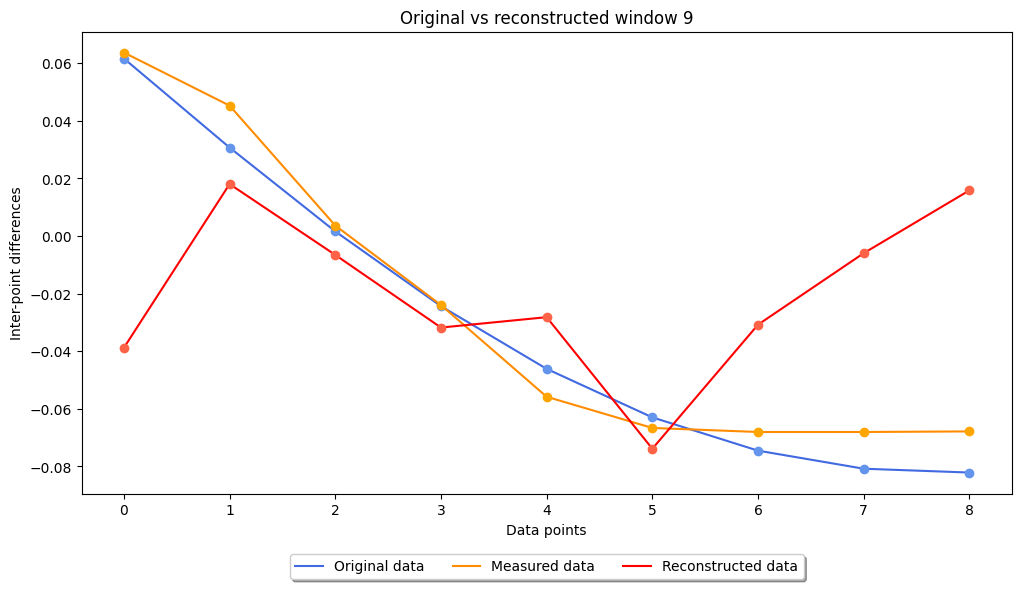

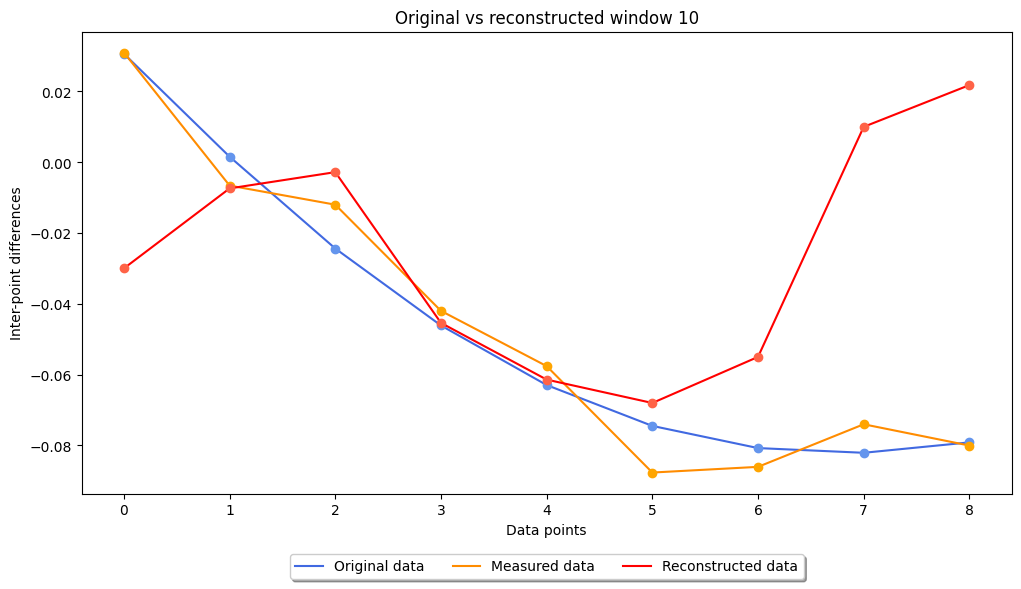

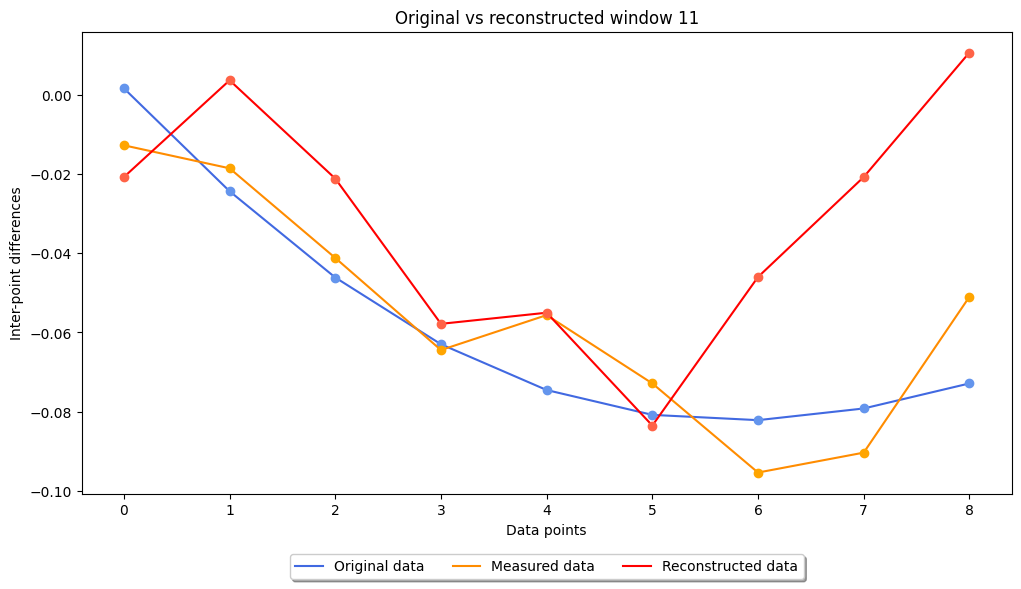

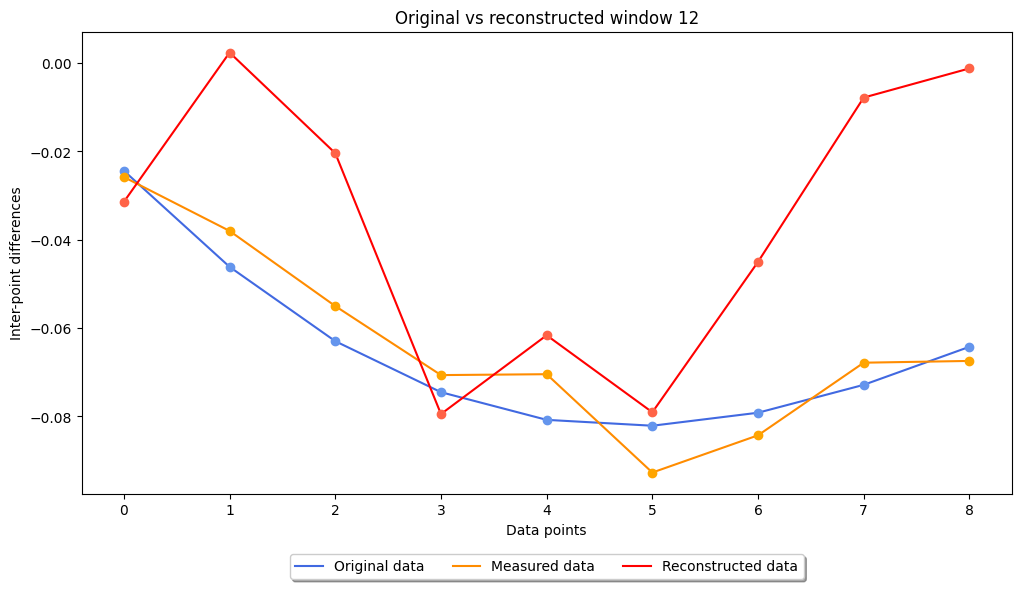

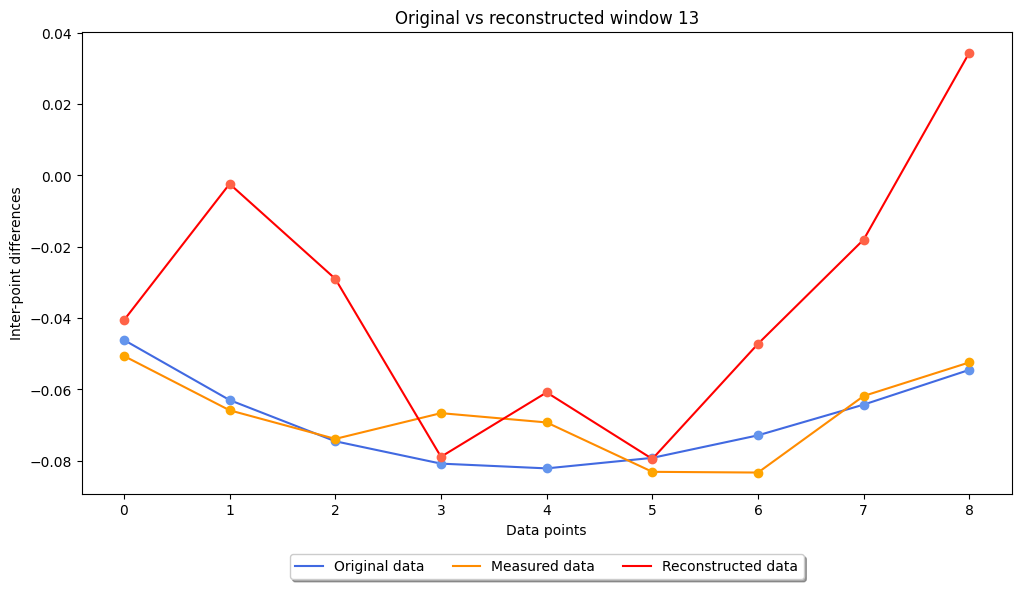

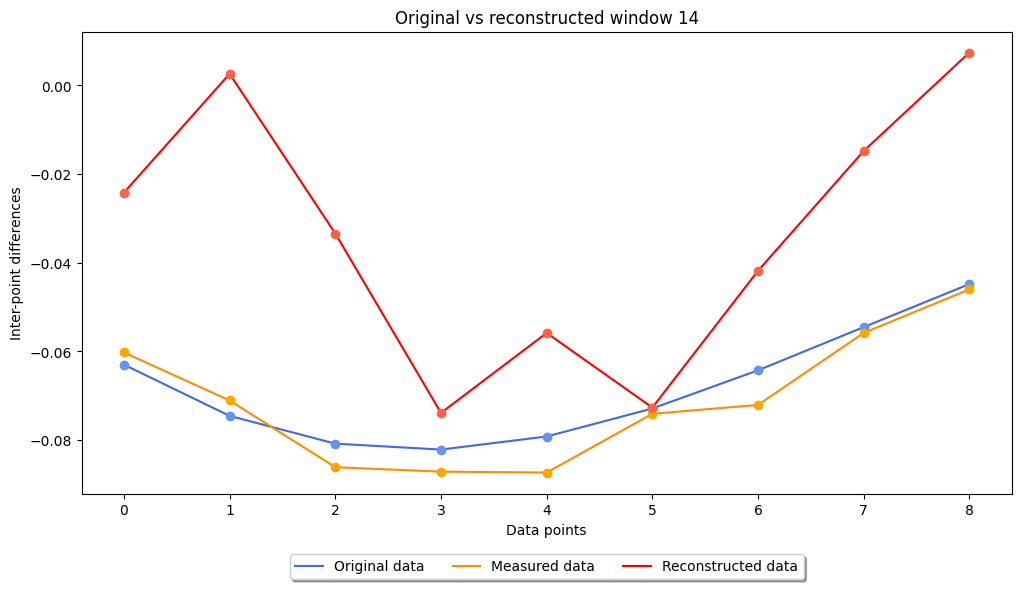

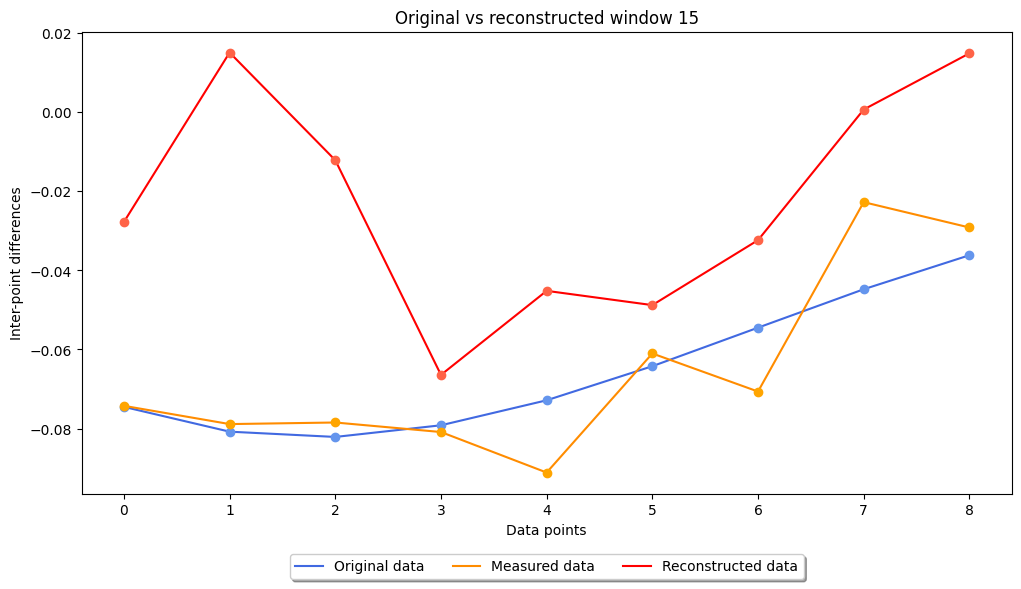

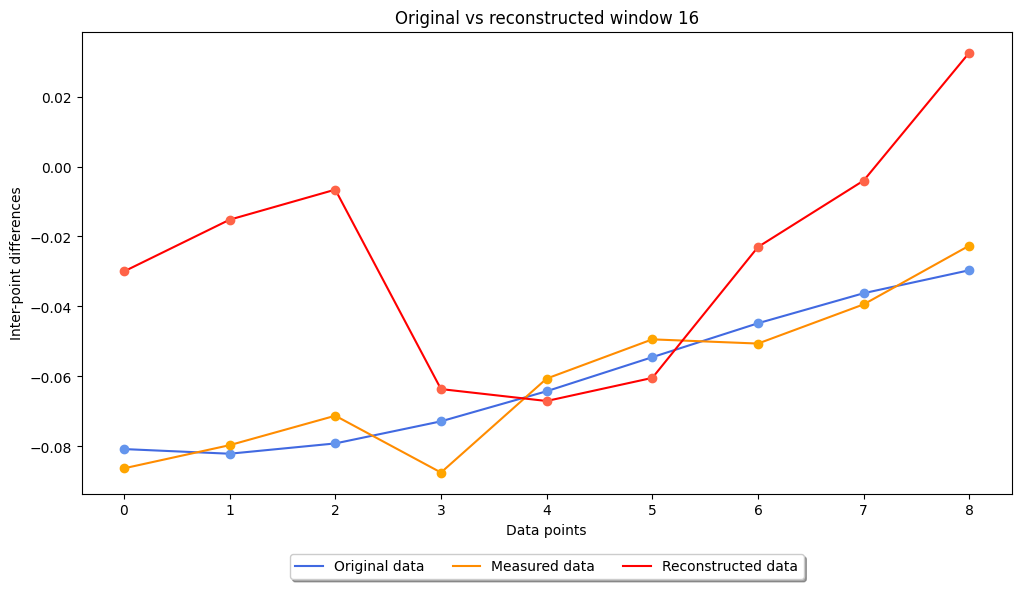

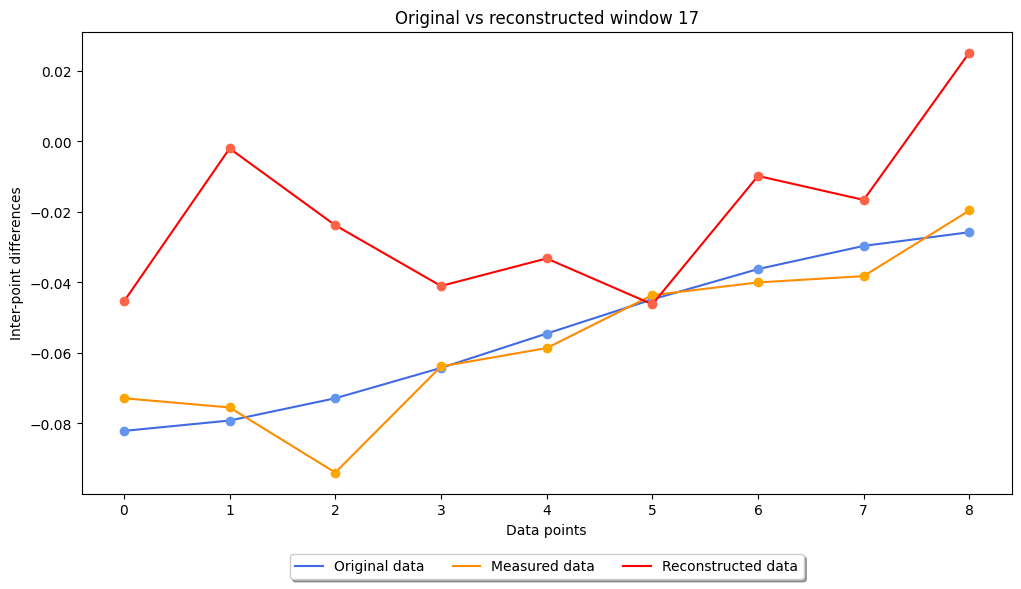

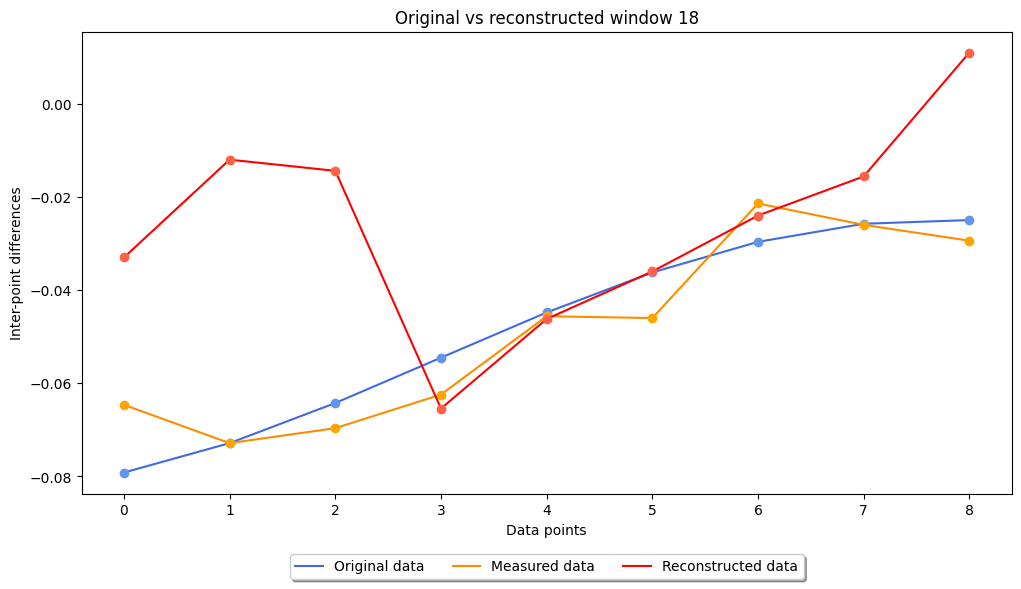

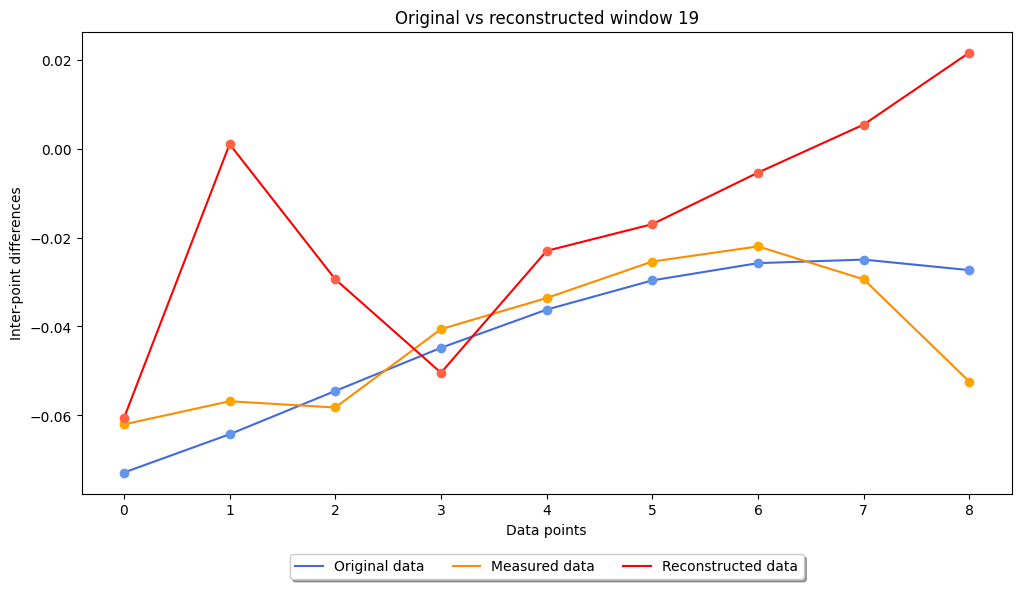

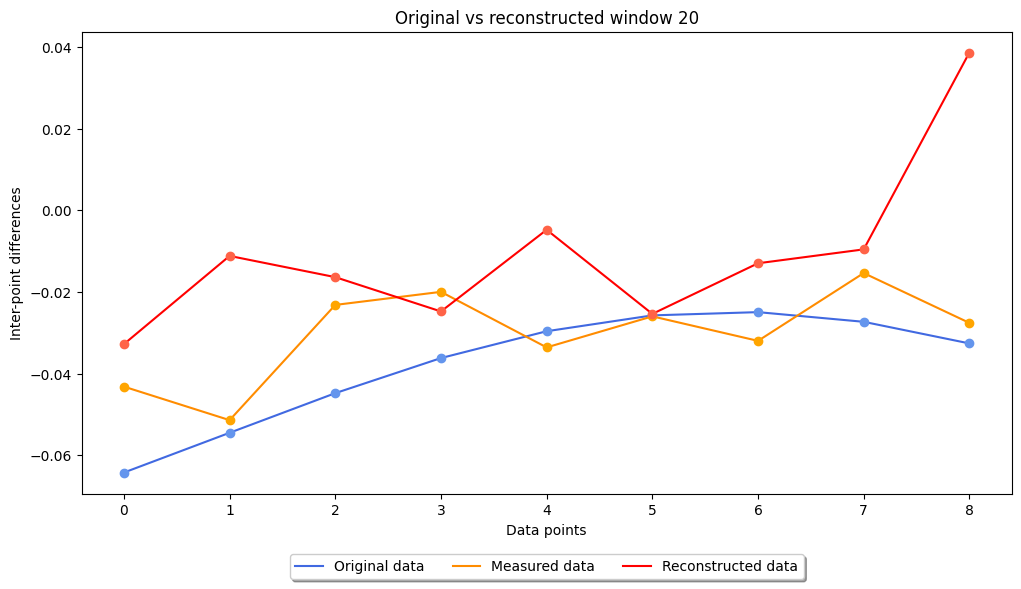

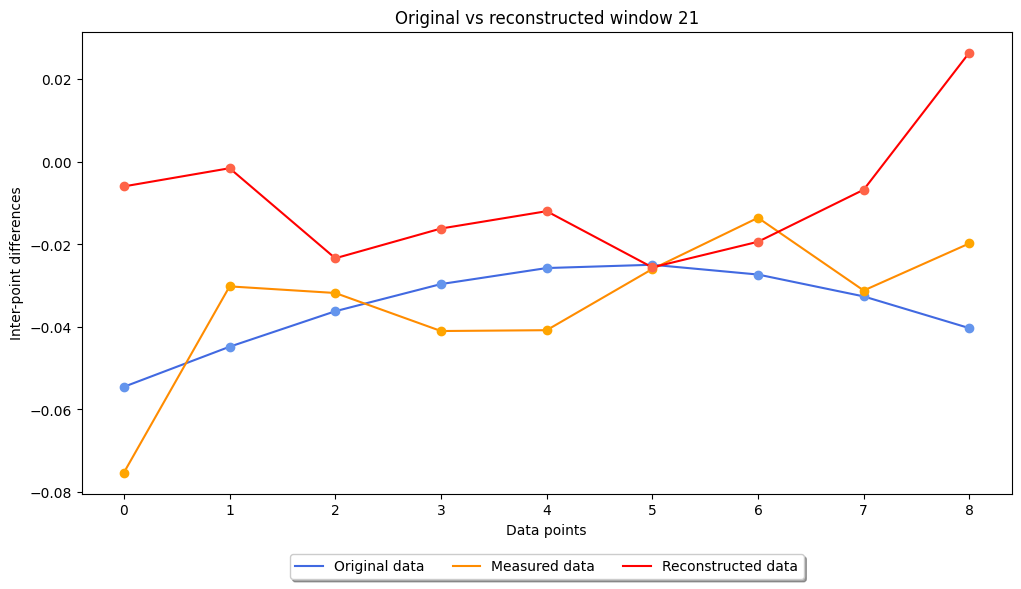

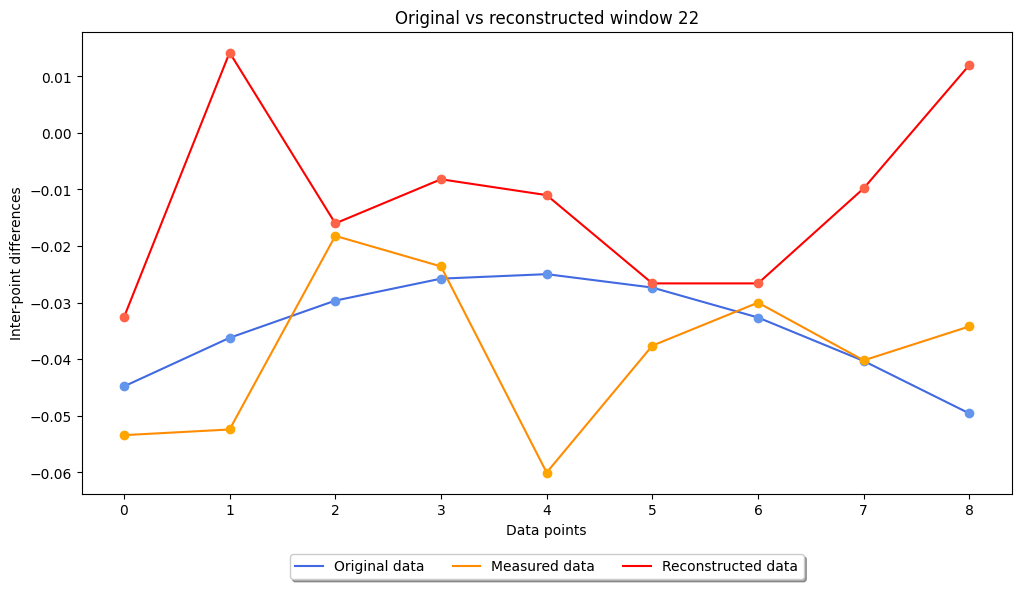

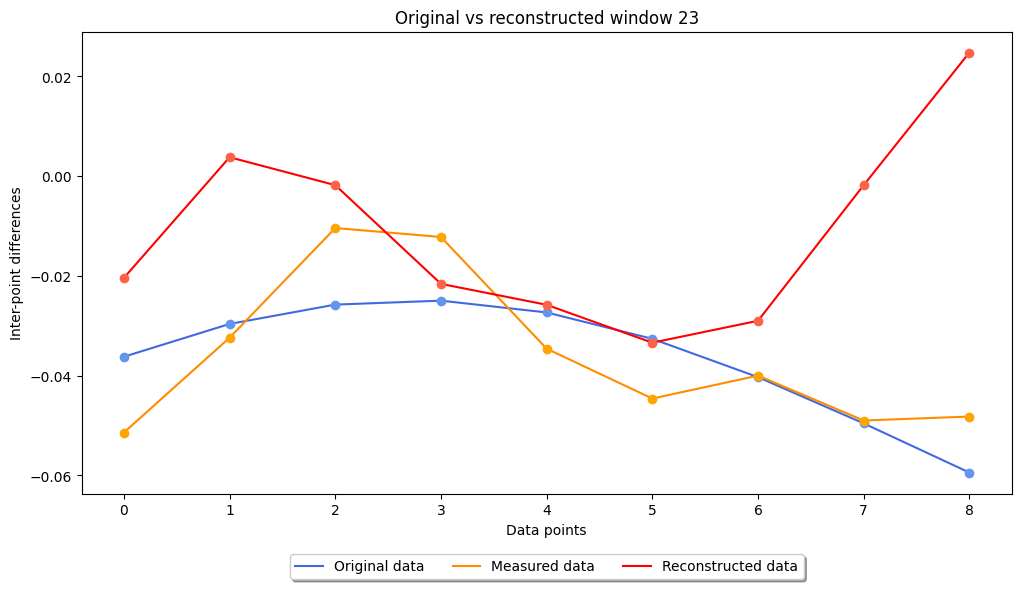

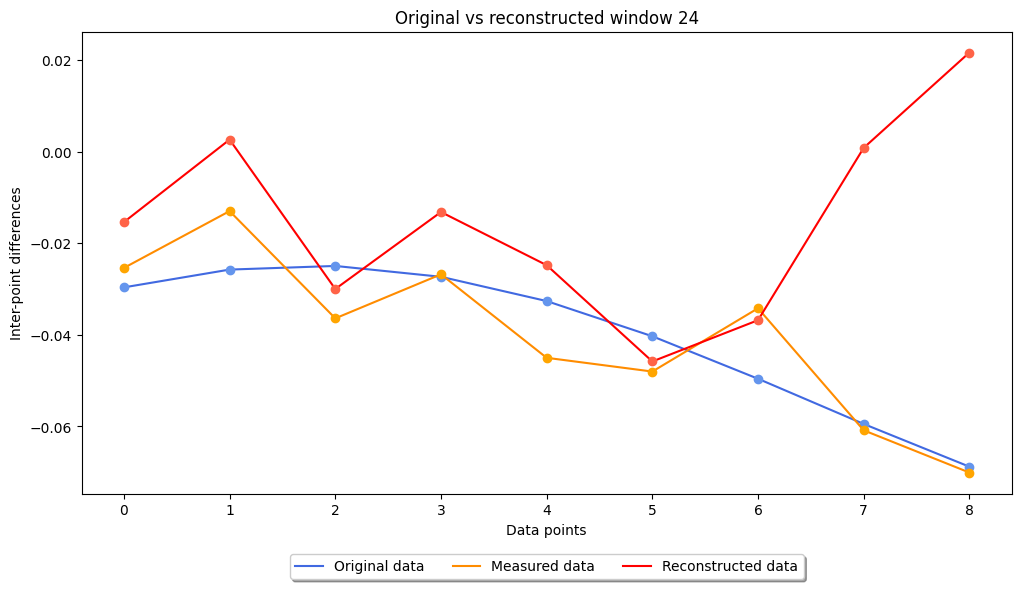

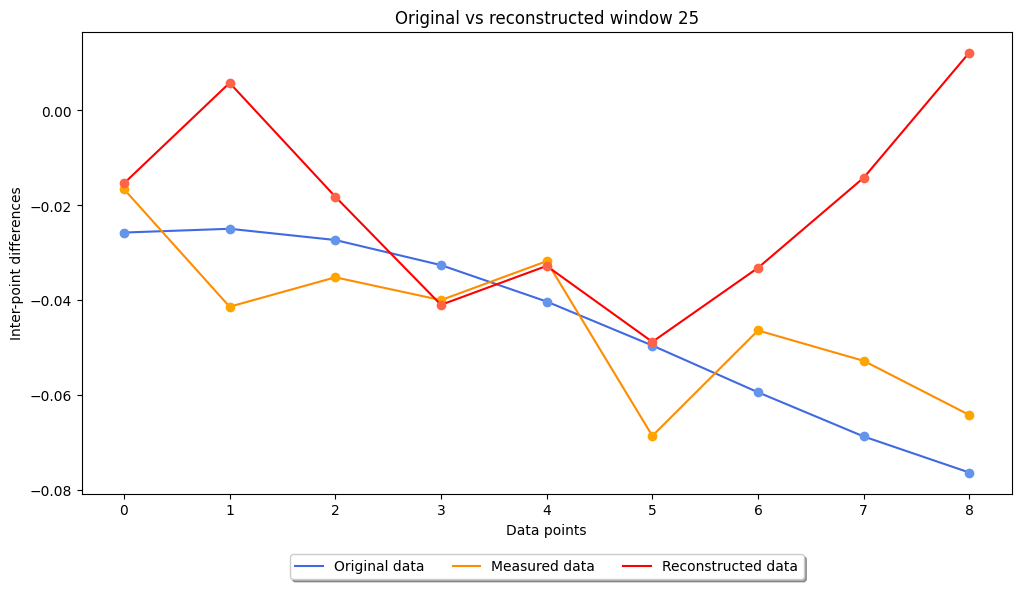

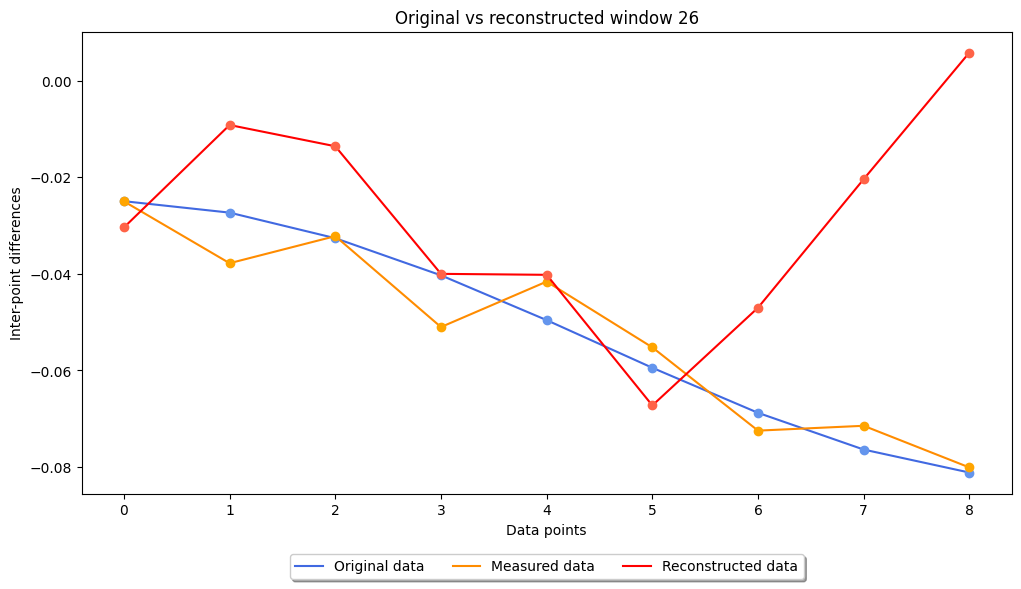

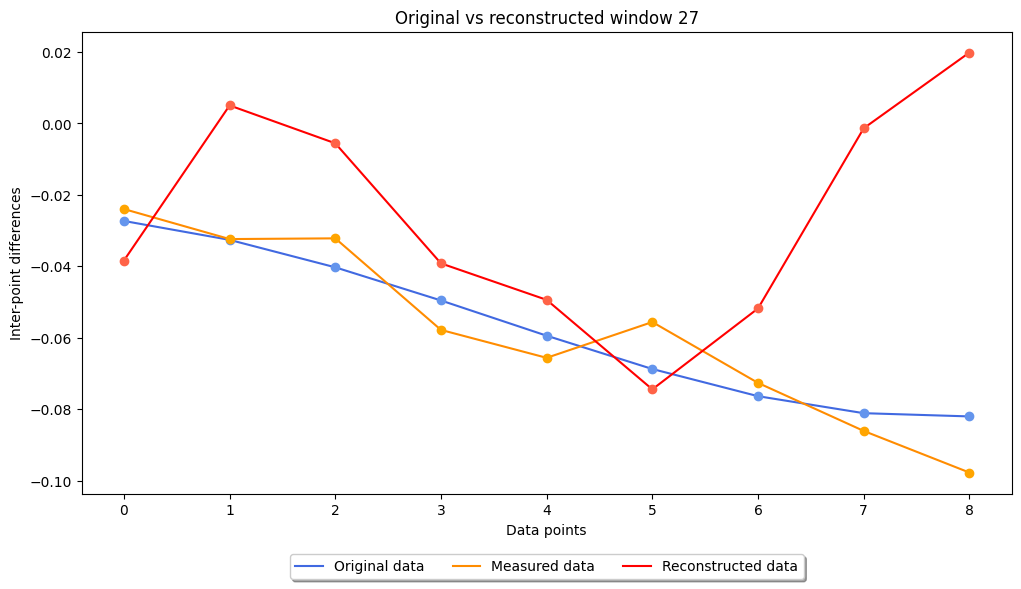

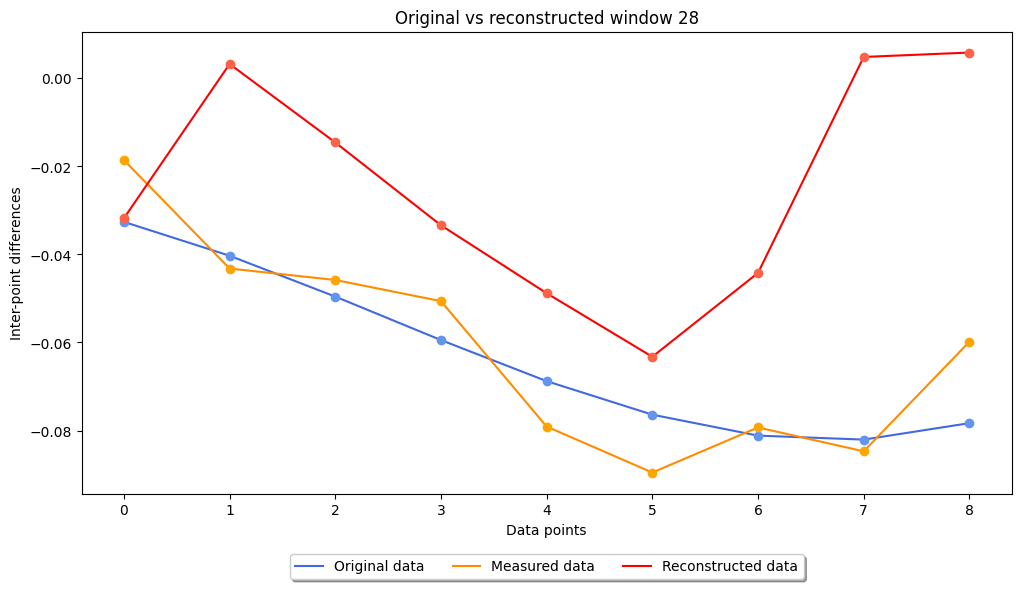

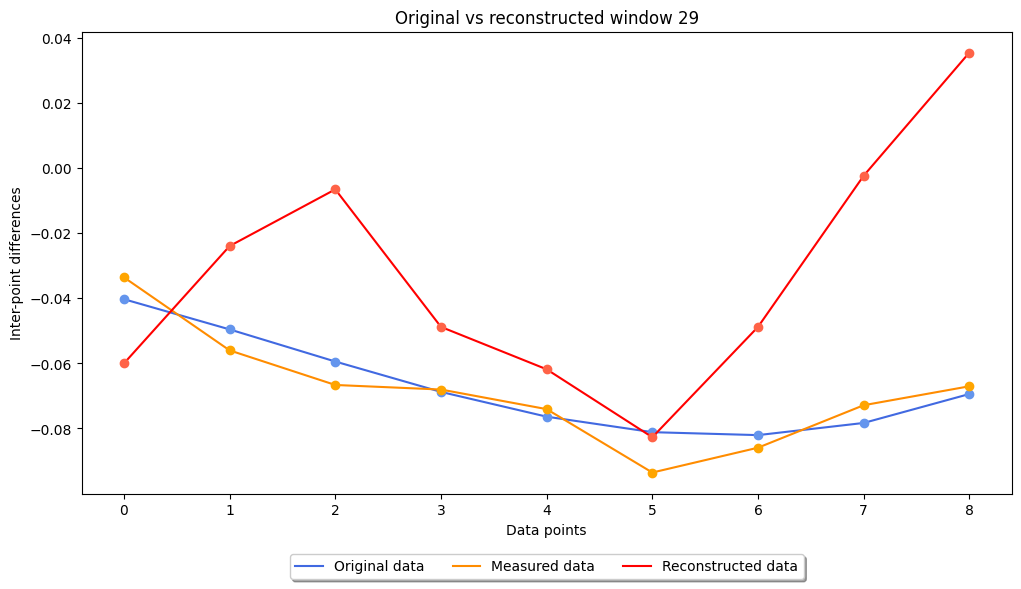

In [57]:
### Plot all the selected windows and their recovered data

for sel_wind in in_org_set.keys():

    # Retrieve window data
    print('\n')
    wind = in_org_set[sel_wind]
    org_meas = in_meas_set[sel_wind]
    out_meas = out_reconstr_set[sel_wind]    
    
    # Plot prepared data
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.title(f'Original vs reconstructed window {sel_wind}')
    plt.xlabel("Data points")
    plt.ylabel("Inter-point differences")
    # plt.xlim(lb, ub)
    
    # Plot target function
    plt.plot([x for x in range(len(wind))], wind, color='royalblue', label='Original data')
    plt.plot([x for x in range(len(wind))], wind, marker='o', color='cornflowerblue', linestyle='None')
    plt.plot([x for x in range(len(wind))], org_meas, color='darkorange', label='Measured data')
    plt.plot([x for x in range(len(wind))], org_meas, marker='o', color='orange', linestyle='None')
    plt.plot([x for x in range(len(wind))], out_meas, color='red', label='Reconstructed data')
    plt.plot([x for x in range(len(wind))], out_meas, marker='o', color='tomato', linestyle='None')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
              ncol=3, fancybox=True, shadow=True)
    plt.show()
    
print('\n')

In [58]:
### Save all calculated data points
to_be_saved_results = False
inorg_file_name = f'qae_angle_inorg_{ent}_reps{reps}_p{len(an_qc.parameters)}.json'
inmeas_file_name = f'qae_angle_inmeas_{ent}_reps{reps}_p{len(an_qc.parameters)}.json'
outrec_file_name = f'qae_angle_outrec_{ent}_reps{reps}_p{len(an_qc.parameters)}.json'

if to_be_saved_results:
    ## Saving results
    with open(inorg_file_name, 'w') as f:
        json.dump(in_org_set, f)
    with open(inmeas_file_name, 'w') as f:
        json.dump(in_meas_set, f)
    with open(outrec_file_name, 'w') as f:
        json.dump(out_reconstr_set, f)
    print(f'Saved results in:\n\t{inorg_file_name}\t{inmeas_file_name}\t{outrec_file_name}')

## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

4. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021

## Performance Statistics

***furies-vengence: ASUS 64Gb RAM***
- CPU Intel i9, 24 cores, 32 threads, 2.2-3.0-4.3-5.4GHz
- GPU NVIDIA GTX 4090, 16384 CUDA Cores, 24 Gb RAM, CUDA V12.3, NVIDIA Driver 545.29.06

GPU Fit (110 samples, 8 qubits, 32 params): **0.00769 min cost, 51.56 sec**<br/>
CPU Fit (110 samples, 8 qubits, 32 params): **0.0051 min cost, 108.36 sec**<br/>
GPU Fit (219 samples, 8 qubits, 32 params): **0.0081 min cost, 84.60 sec**<br/>
GPU Fit (274 samples, 10 qubits, 40 params): **0.01054 min cost, 107.91 sec**<br/>
GPU Fit (274 samples, 10 qubits, 50 params): **0.00447 min cost, 203.52 sec**<br/>
GPU Fit (276 samples, 6 qubits, 30 params): **0.00779 min cost, 151.55 sec**<br/>
GPU Fit (275 samples, 8 qubits, 40 params): **0.00313 min cost, 111.15 sec**<br/>
GPU Fit (275 samples, 8 qubits, 40 params): **0.00305 min cost, 104.88 sec** (loaded and more training - ignored)

***basilisk: Lenovo 32Gb RAM***
- CPU Intel i7, 4 cores, 8 threads, 2.8GHz - No GPU

CPU Fit (110 samples, 8 qubits, 32 params): **0.00744 min cost, 226.05 sec**<br/>
CPU Fit (275 samples, 8 qubits, 32 params, 400 epochs): **0.00512 min cost, 797.54 sec**<br/>
CPU Fit (275 samples, 8 qubits, 32 params, 250 epochs): **0.00623 min cost, 531.32 sec**<br/>
CPU Fit (275 samples, 8 qubits, 18 params, 250 epochs): **0.00314 min cost, 308.64 sec** (Bravo-Prieto - terrible)<br/>
CPU Fit (275 samples, 8 qubits, 18 params, 125 epochs): **0.00407 min cost, 155.59 sec** (Bravo-Prieto - terrible)<br/>
CPU Fit (275 samples, 8 qubits, 18 params, 125 epochs): **0.00684 min cost, 157.55 sec** (Bravo-Prieto - terrible)<br/>
CPU Fit (275 samples, 8 qubits, 18 params, 125 epochs): **0.00329 min cost, 154.95 sec** (Bravo-Prieto - terrible)

***goblin-galore: Tomahawk 64Gb RAM***
- CPU Intel i7, 6 cores, 12 threads, 3.5GHz - 2 GTX NVIDIA 1080 T1 GPUs, CUDA V12.2, NVIDIA Driver 535

CPU Fit (275 samples, 8 qubits, 32 params, 400 epochs): **0.00456 min cost, 695.26 sec**<br/>
CPU Fit (274 samples, 10 qubits, 40 params, 400 epochs): **0.00364 min cost, 2430.50 sec**

## Logs

**Qiskit QAE with Unary Encoding**
- V1 Using QAE for anomaly detection (by denoising)
    - V1.1 Tested binary encoding, which misses proximity
    - V2.0 Created an "unary" encoding scheme
    - V2.1 Unary encoding tested with various options, not close
      - Issues noted:
          - Issue 01 (Completed) *Not sure how to interpret the output - cannot be visual*
          - Issue 02 (Completed) *Visual match between input and output not close*
          - **Issue 03** *Noise needs to be injected in training*
          - Issue 04 (Completed) *Training is getting slow, need to use GPU*
          - **Issue 05** *It is worth testing if an increase of the latent or trash layers could improve the result*
      - Action planned:
          - *Add Aer GPU*, *Add noise in training*, *Add convolution*, *Create classical solution to compare*
    - V2.2 Adding GPU plus encoding test
      - Encoding test:
          - Tested amplitude encoding. To improve the QAE we may need to focus on other aspects of the model,
            e.g. incorporation of noise and improvement to the ansatz to ensure neighbourhoods are strongly
            entangled.
      - Several problems installing GPU support, attempt to address **Issue 04**
          - Issue 06 (Completed) *Several problems associated with GPU support*<br/>
          - **Fix 06** *Need to install ML 0.7.1+ and Aer 0.13.2+*<br/>
            ML 0.7.1 standard installation (no need to install from source anymore)<br/>
            Aer 0.13.2 requires CUDA + cuQuantum + cuTensor (Deb)<br/>
            - Note that Aer Sampler has a bug and will not work with RawFeatureVector.
          - **Fix 04** *With GPU the training speed increased ~2 times
    - V2.3 Attempt to move to PuTorch, abandoned for the time being
    - V2.4 Changing to angle encoding - relative with Ry over 2pi
      - Issues noted:
          - Issue 07 (Completed) *Negative numbers not coded properly*</br>
      - Action planned:
          - *Change encoding as relative from H over pi* - with [-1:0] pi/2 negatives towards |0> and [0:+1] pi/2 positives towards |1>
    - V2.5 Completed QAE with angle encoding, lots of fixes
      - Fixes completed:
          - **Fix 07** *Adopted encoding around H state, up negative, down positive*
          - **Fix 02** *Resulting QAE outputs better match the inputs*
          - **Fix 01** *With the new encoding, the output is easy to interpret*
      - Issues noted:
          - *Issue 08* (Partially Completed) *QAE reconstruction has large variance end of windows*, averaging overlapping windows may help
          - **Issue 09** *Need to reconstruct the entire series*, possibly with averaging of overlapping windows
      - Action planned:
          - **Issue 10** *Systematically experiment with:* data sets, window size, step size, trash size, qubit no, ansatz reps and entanglement type
    - V2.6 Testing various QAE configurations
      - Varied the number of qubits (8 was best) and asatz reps (4 was best)
      - Issues noted:
          - Issue 11 (Completed) *Random seed seems to have little effect on results*
          - Issue 12 (Completed) *QAE results tend to be close to zero at the window ends, e.g. 1st and 7th value [0..7]*
          - Issue 13 (Completed) *Related to #12, the first window value should not be zero but the diff with the value from the previous window*<br/>
            Change the order of processing - first create deltas, then split into windows, change TS value encoding and decoding (no need to delta)
    - V2.7 Testing with an older computer Tomahawk, 64Gb RAM, 2 x GeForce GTX 1080 Ti, also testing the enhance encoding of Bravo-Prieto [4]
      - Issues noted:
          - **Issue 14** *GPU failed with error:*<br/>
            Simulation failed and returned the following error message:<br/>
            ERROR:  [Experiment 0] This program was not compiled for SM 61<br/>
            Reason (as provided on Slack), CuQuantum does not support GTX 1080 GPUs (cat.SM 61) - may not be fixable, GPU too old
          - Issue 15 (Completed) *A series of experiments with Bravo-Prieto's algorithm failed to produce any results*
      - Fixes completed:
          - **Fix 15** Bravo-Prieto algorithm could not be reproduced in any form, and with all possible options - it was abandoned*
      - CPU run works well - faster than Lenovo, results are pretty good (as per V2.6)
    - V2.8 Fixed incorrect coding of the first window value
      - Fixes completed:
          - **Fix 11** *Added **seed-simulator** to the backend options for GPU, this may be added for CPU when using AerSampler for CPU*
          - **Fix 12-13** *The first window encoded value is now delta of the first value minus the last value from the previous window*<br/>
            This was achieved by encoding the entire time series first, before splitting it into windows<br/>
            Additional charts were provided to show the original data, encoded sequence, and testing sequence<br/>
            QAE results at the edges of a window are non zero
      - Action planned:
          - Noted high accuracy of results in the middle of all windows, however, the edges are inacurate - see **Issues 08, 12**<br/>
            This may be related to the ansatz measurement issues, a possible approach would be to reject the values on edges<br/>
            To test this we need to experiments with larger windows
    - V2.9 Tested QAE with windows of size 10 - great results
      - Fixes completed:
          - **Fixed 08** *When testing with widnows of size 8 and 10, the edge inaccuracy persists but shifts*<br/>
            This may be the feature of the approach with Swap Test training
      - Action planned:
        This run was saved and the generated parameters and data will be used to address **Issue 9** (reconstruction of the series)
    - V2.10 Started a cleanup of all code
      - A test was conducted to create a QAE with 6 latent and 3 trash qubits. Its results were disappointing. The notebook, however, was copied to the Runs folder.

In [59]:
import qiskit.tools.jupyter

# Note that Qiskit Terra and ML were compiled in from sources
%qiskit_version_table

# As this code was derived from Qiskit tutorial retain the following
%qiskit_copyright